In [2]:
# machine learning
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from matplotlib.patches import Rectangle, Circle

# geo
from osgeo import gdal
import osr

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# additional
import itertools
import pandas as pd
import datetime as dt
import math
import numpy as np
import random
import time
import copy


%matplotlib inline



# define path to classification data
path = f'data/classification_data/'
path_comp = f'data/composites/'
path_coef = f'data/coefficients/'

yearAS = 2004

""" //////////////////////// classes //////////////////////// """

# class to create a deep neural network (dnn). the dnn object is compatible with scikit-learn's
# classifier, i.e. also provides the fit and predict methods.
class DeepNeuralNetwork():
    
    def __init__(self):
        self.trained = False
        self.enc = OneHotEncoder(categories='auto')
        self.model = False
        self.input_dim = 0
        self.output_dim = 0
        
        # end of init method
    
    def fit(self, X_train, y_train):
        
        sample_weights = class_weight.compute_sample_weight('balanced', y_train)
        
        # one hot encoding data
        y_train_onehot = np.asarray(y_train)
        self.enc.fit(y_train_onehot.reshape(-1,1))
        y_train_onehot = self.enc.transform(y_train_onehot.reshape(-1,1)).todense()
        
        # getting input and output dimension of data
        self.input_dim = len(X_train.columns)
        self.output_dim = y_train_onehot.shape[1]
        # 400 200 100 100 6
        # setting up model
        self.model = keras.Sequential([
            keras.layers.Dense(400, input_dim=self.input_dim, activation=tf.nn.tanh),
            keras.layers.Dense(200, activation=tf.nn.tanh),
            keras.layers.Dense(100, activation=tf.nn.tanh),
            keras.layers.Dense(self.output_dim, activation=tf.nn.softmax)
        ])
        opt = keras.optimizers.Adam(lr=0.001)
        self.model.compile(
          optimizer=opt,
          loss='categorical_crossentropy',
          metrics = ["accuracy"]
        )
        
        # training deep neural network
        batchsize = 256
        for i in range(6):
            # print(batchsize)
            self.model.fit(X_train, y_train_onehot, epochs=20, batch_size=batchsize, sample_weight=sample_weights, verbose=0)
            batchsize *= 2
        
        self.trained = True
        # end of fit method
    
    def set_model(self,model):
        
        self.model = model
        self.trained = True
        
    def __deepcopy__(self,memo):
        # model_copy = tf.keras.models.clone_model(self.model)
        
        self.model.save_weights('model_weights.h5')
        model_copy = keras.Sequential([
            keras.layers.Dense(400, input_dim=self.input_dim, activation=tf.nn.tanh),
            keras.layers.Dense(200, activation=tf.nn.tanh),
            keras.layers.Dense(100, activation=tf.nn.tanh),
            keras.layers.Dense(self.output_dim, activation=tf.nn.softmax)
        ])
        model_copy.compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ["accuracy"]
        )
        model_copy.load_weights('model_weights.h5')
        dnn_copy  = DeepNeuralNetwork()
        dnn_copy.set_model(model_copy)
        return dnn_copy
        

    def predict(self, X_test):
        
        if self.trained:
            y_pred = np.argmax(self.model.predict(X_test), axis=1)
        
        return y_pred
        # end of predict method

        
# class that provides methods to assess classification results by implementing various accuracy metrics.
class ErrorMatrix:

    def __init__(self, y_ref, y_pred, labels=False):
        
        self.y_ref = list(y_ref)
        self.y_pred = list(y_pred)
        self.n_classes = len(np.unique(self.y_ref))
        
        self.matrix = np.zeros((self.n_classes,self.n_classes),dtype=np.int)
        for r, p in zip(y_ref,y_pred):
            self.matrix[p,r] = self.matrix[p,r]+1
        
        self.labels = labels if labels else list(range(self.n_classes))
        
    def set_matrix(self, matrix, labels=False):
        self.matrix = matrix
        
        self.y_ref, self.y_pred = ([],[])
        for index, x in np.ndenumerate(self.matrix):
            for _ in range(x):
                self.y_ref.append(index[1])
                self.y_pred.append(index[0])
                
        self.n_classes = len(np.unique(self.y_ref)) 
        self.labels = labels if labels else list(range(self.n_classes))
        
    def column_total(self):
        return list(np.sum(self.matrix, axis=0))
        
    def row_total(self):
        return list(np.sum(self.matrix, axis=1))
    
    def total(self):
        return sum(self.column_total())
                
    def users_accuracy(self,i):
        total = np.sum(self.matrix[i,:])
        if total==0: return 0.0
        else: return self.matrix[i,i]/float(total)*100
    
    def users_accuracies(self):
        uas = [self.users_accuracy(i) for i in range(self.n_classes)]
        return uas

    def average_users_accuracy(self):
        return np.mean(self.users_accuracies())

    def producers_accuracy(self,i):
        total = np.sum(self.matrix[:,i])
        if total==0: return 0.0
        else: return self.matrix[i,i]/float(total)*100
    
    def producers_accuracies(self):
        pas = [self.producers_accuracy(i) for i in range(self.n_classes)]
        return pas
    
    def average_producers_accuracy(self):
        return np.mean(self.producers_accuracies())
    
    def overall_accuracy(self):
        correctly_classified = sum([self.matrix[i,i] for i in range(self.n_classes)])
        total = sum(list(np.sum(self.matrix, axis=1)))
        oa = correctly_classified/float(total)*100
        return oa
    
    def average_accuracy(self):
        aa = np.mean(self.users_accuracies())
        return aa

    def mean_accuracy(self):
        ma = (self.average_accuracy()+self.overall_accuracy())/2.
        return ma
     
    def kappa(self):  
        # Cohen's kappa (Cohen, 1960; doi:10.1177/001316446002000104)
        return cohen_kappa_score(self.y_ref,self.y_pred)
    
    def score(self):    
        return self.mean_accuracy()
    
    def accuracy_metrics(self):   
        metrics = {
            'OA': self.overall_accuracy(),
            'AA': self.average_accuracy(),
            'MA': self.mean_accuracy(),
            'Kappa': self.kappa()
        }
        return metrics
            
    def print_matrix(self):  
        print(self.matrix)
        
    def print_summary(self):      
        
        print(f'Summary statistics (n Samples: {self.total()})',end='\n\n')    
        
        # overall statistics
        oa = self.overall_accuracy()
        aa = self.average_accuracy()
        ma = self.mean_accuracy()
        kappa = self.kappa()
        print(f'{oa:.1f} % (OA); {aa:.1f} % (AA); {ma:.1f} % (MA); {kappa:.3f} % (kappa).',end='\n\n')
        
        # class wise statistics
        column_total = self.column_total()
        row_total = self.row_total()      
        uas = self.users_accuracies()
        pas = self.producers_accuracies()      
        for i, label in enumerate(self.labels):
            print(f'{label}: {uas[i]:.2f} % (UA) n Class: {row_total[i]}; {pas[i]:.2f} % (PA) n Ref: {column_total[i]})')
        print()
        
    def write2latex(self,fname):
        
        labels = ['Artificial areas','Non-forest veg.','Forest veg.','Bare land','Water','Snow \& Ice']
        labels_short = ['AA','NFV','FV','BL','W','SI']
        f = open(f'{fname}.txt', 'w')
        f.write('\\begin{table}[h!] \n')
        f.write('\\begin{center} \n')
        f.write('\\caption{Error matrix.} \n')
        f.write('\\label{tab:error_matrix} \n')
        f.write(f'\\resizebox{{0.99\\textwidth}}{{!}}{{\\begin{{tabular}}{{ll{"r"*(self.n_classes+3)}}} \n')
        f.write('\\toprule \n')
        
        classified = '\\multicolumn{2}{l}{Classified as (pixels)}'
        reference = f'\\multicolumn{{{self.n_classes+1}}}{{c}}{{Reference data (pixels)}}'
        f.write(f'{classified} & {reference} & UA (\\%) & PA (\\%) \\\ \n')
        labels_joined = ' & '.join(labels_short)
        f.write(f'& & {labels_joined} & Total & & \\\ \n')        
        f.write(f'\\cmidrule{{1-{self.n_classes+5}}} \n')             
        
        totals = self.row_total()
        uas = self.users_accuracies()
        pas = self.producers_accuracies()
        for i in range(self.n_classes):
            counts = [f'{count:,}' for count in self.matrix[i,:]]
            counts[i] = f'\\textbf{{{counts[i]}}}'    
            line = ' & '.join(counts)
            line =  f'{labels[i]} & {labels_short[i]} & {line} & {totals[i]} & {uas[i]:.1f} & {pas[i]:.1f} \\\ \n'        
            f.write(line)
            
        line = ' & '.join([f'{t}' for t in self.column_total()])
        line = f'& Total & {line} & {self.total()} & & \\\ \n'
        f.write(line)
        f.write('\\bottomrule \n')
        f.write('\\end{tabular}} \n')
        f.write('\\end{center} \n')
        f.write('\\end{table}')
        f.close()
        # end of matrix to latex function
                
    def users_producers2latex(self,fname,labels=False):        
        labels = labels if labels else [f'{i}' for i in range(self.n_classes)]
        f = open(f'{fname}.txt', 'w')
        line = ' & '.join([f'{ua:.2f}' for ua in self.users_accuracies()])
        f.write(f'{line} \\\ \n')
        line = ' & '.join([f'{pa:.2f}' for pa in self.producers_accuracies()])
        f.write(f'{line} \\\ \n')        
        f.close()
        # end of user producer to latex function

        

""" //////////////////////// functions //////////////////////// """


# function to get arealstatistik data collection year for campaign and roi
def collection_year(roi,yearAS):
    
    if yearAS == 2004:
        if roi=='roi1': return 2007
        if roi=='roi2': return 2006
        if roi=='roi3': return 2004
    if yearAS == 2013:
        if roi=='roi1': return 2016
        if roi=='roi2': return 2015
        if roi=='roi3': return 2013

                
# function to read in a data cube from a geo tiff file
def geotiff_to_datacube(fname):
    
    ds = gdal.Open(fname)
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function
    
    
def save_geotiff(data_cube,geotransform,epsg,fname):
    
    n_rows, n_cols = data_cube.shape[0:2]
    n_bands = data_cube.shape[2] if len(data_cube.shape)>2 else 1
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    if n_bands==1:
        ds.GetRasterBand(1).WriteArray(data_cube[:,:])
    else:
        for i_band in range(n_bands):
            ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None
    # end of save function
    

# function to classify a feature image with a trained classifier
def classify(trained_clf,fname,spatial):
    
    features, geotransform, epsg = geotiff_to_datacube(fname)
    shape = features.shape 
    if not spatial:
        pixel_vector = features.reshape((shape[0]*shape[1], shape[2]))
    else:
        padded_features = np.pad(features, pad_width=((1,1),(1,1),(0,0)), mode='edge') 
        features = False # freeing some memory
        pixel_vector = np.zeros((shape[0]*shape[1],shape[2]*9))
        for irow in range(0,shape[0]):
            for icol in range(0,shape[1]):
                irowpad, icolpad = (irow+1,icol+1)
                kernel = padded_features[irowpad-1:irowpad+2,icolpad-1:icolpad+2,:]
                pixel_vector[irow*shape[1]+icol] = kernel.flatten()
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    features_classified = predictions.reshape((shape[0],shape[1]))
        
    return features_classified, geotransform, epsg
    # end of classify function
    
                
# function to plot a classified image  
def plot(image_classified):
     
    # define class labels and colors
    classes = [
        'Artificial areas',
        'Grass, herb and brush vegetation',
        'Tree vegetation',
        'Bare land',
        'Water',
        'Glacier, perpetual snow'
    ]
    
    hex_colors = [
        "#FF0000",
        "#FFFF00",
        "#00B200",
        "#804D33",
        '#0000FF',
        '#B2B2B2'
    ]
    
    cmap = mpl.colors.ListedColormap(hex_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,6), cmap.N)
        
    # plot map
    fig, ax = plt.subplots(figsize=(10,10))        
    im = ax.imshow(image_classified, cmap=cmap, norm=norm)

    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,6,7))
    cbar.ax.set_yticklabels(classes)
    plt.show()
    # end of plot function
                
def plot_classification(ax,fname,show_xlabels=True,show_ylabels=True):
    
    classes = ['Artificial areas', 'Grass, herb and brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
    hex_colors = ["#FF0000","#FFFF00","#00B200","#804D33",'#0000FF','#B2B2B2']
    
    cmap = mpl.colors.ListedColormap(hex_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,6), cmap.N)
    
    classification, geotransform, epsg = geotiff_to_datacube(fname)
    shape = (classification.shape[0], classification.shape[1], 1)
    
    im = ax.imshow(classification[:,:,0], cmap=cmap, norm=norm)
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,shape[1]//2,shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:,.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:,.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    return im
    # end of plot roi function
    
      
def train_validate_classifier(clf, train, test, features, label):
        
    # getting training and testing features
    X_train = train[features]
    X_test = test[features]
    
    # getting training and testing labels
    y_train = train[label]
    y_test = test[label]
    
    # training classifier
    start_time = time.time()
    clf.fit(X_train,y_train)
    run_time = time.time() - start_time
    
    # creating error matrix for validation
    y_pred = clf.predict(X_test)
    
    return ErrorMatrix(y_test, y_pred), run_time, clf

                
# gaussian filter functions
def apply_gaussian_kernel(data_kernel,gaussian_kernel):
    
    assert(data_kernel.shape==gaussian_kernel.shape)
    
    class_probabilities = {}
    for index, prob in np.ndenumerate(gaussian_kernel):
        class_ = int(data_kernel[index[0],index[1]])
        class_prob = class_probabilities.get(class_,0)
        class_probabilities[class_] = class_prob + prob
    
    new_class = max(class_probabilities, key=class_probabilities.get)
    return new_class


def gaussian_filter(image,kernel_size):
    
    kernel5 = np.array([
        [1,4,7,4,1],
        [4,16,26,16,4],
        [7,26,41,26,7],
        [4,16,26,16,4],
        [1,4,7,4,1]
    ])

    kernel3 = np.array([
        [1,2,1],
        [2,4,2],
        [1,2,1]
    ])
    
    gaussian_kernel = kernel3 if kernel_size==3 else kernel5 
    offset = gaussian_kernel.shape[0]//2

    filtered_image = np.copy(image)
    padded_image = np.pad(image, pad_width=((offset,offset),(offset,offset),(0,0)), mode='edge')
    
    # loop over all pixels ignoring edges
    for i in range(offset,padded_image.shape[0]-offset):
        for j in range(offset,padded_image.shape[1]-offset):
        
            data_kernel = padded_image[i-offset:i+offset+1,j-offset:j+offset+1,0]
            class_filtered = apply_gaussian_kernel(data_kernel,gaussian_kernel)
            filtered_image[i-offset,j-offset,0] = class_filtered
            
    return filtered_image


def validate_filtered(trained_clf,spatial,test,feature_image,label):
    
    y_test, y_pred = ([],[])
    
    for roi in rois:
        
        # subsetting test data to roi
        test_roi = test[test['roi']==roi]
        x_coords = list(test_roi['X'])
        y_coords = list(test_roi['Y'])
        labels = list(test_roi[label])
        
        # getting image data for roi
        year = 2006 if roi=='roi2' else 2007
        image, geotransform, epsg = geotiff_to_datacube(f'{feature_image}_{roi}_{year}.tif')
        xOrigin = geotransform[0]
        yOrigin = geotransform[3]
        pixelWidth = geotransform[1]
        pixelHeight = -geotransform[5]
        
        for i, (x_coord,y_coord,class_) in enumerate(zip(x_coords,y_coords,labels)):
            
            # computing column and row indices
            icol = int((x_coord - xOrigin) / pixelWidth)
            irow = int((yOrigin - y_coord ) / pixelHeight)

            if not spatial:
                
                # create vector of pixels for classifier input
                kernel = image[irow-1:irow+2,icol-1:icol+2,:]
                feature_vector = kernel.reshape((3*3, kernel.shape[2]))
            
            else:
                
                # create vector of kernels for classifier input
                feature_vector = []
                for irowk in range(irow-1,irow+2):
                    for icolk in range(icol-1,icol+2):
                        kernel = image[irowk-1:irowk+2,icolk-1:icolk+2,:]
                        kernel_flattened = kernel.flatten()
                        feature_vector.append(kernel_flattened)
                feature_vector = np.array(feature_vector)
                if i ==0: print(feature_vector.shape)
                                            
            # classify pixel vector and reshape to image
            predictions = trained_clf.predict(feature_vector)
                
            classified_kernel = predictions.reshape((3,3))
        
            class_pred = apply_gaussian_kernel(classified_kernel,gaussian_kernel3)
            
            y_test.append(class_)
            y_pred.append(class_pred)
                
    
    error_matrix = confusion_matrix(y_test, y_pred)
    
    # computing average user's and producer's accuracy
    avg_uacc = compute_avg_uacc(error_matrix)
    avg_pacc = compute_avg_pacc(error_matrix)
    
    return (avg_uacc, avg_pacc)

In [3]:
data_coefs = pd.read_csv(f'{path}coefficients_labeled_as{yearAS}.csv')
data_coefs.head()

roi       X       Y  land_cover  topleft_blue_c  topleft_blue_a1  \
0  roi1  667600  237700           1      430.247589        -4.346140   
1  roi1  667600  237800           2      328.148468        34.003731   
2  roi1  667600  237900           2      267.022400       -23.944775   
3  roi1  667600  238000           2      316.303864        36.062489   
4  roi1  667600  238100           2      285.278870       -24.541515   

   topleft_blue_b1  topleft_green_c  topleft_green_a1  topleft_green_b1  ...  \
0       -41.496170       806.920349        -58.442146        -95.429054  ...   
1        31.237612       535.412781          5.096352         59.066689  ...   
2        30.421154       422.210815        -88.935143         46.191063  ...   
3       -28.380636       487.278351          4.214088         -6.462491  ...   
4        26.182205       505.166382        -82.867439         41.132927  ...   

   lowerright_red_b1  lowerright_nir_c  lowerright_nir_a1  lowerright_nir_b1  \
0        -144.079315       3831.171631        -238.796066         300.937561   
1          29.213007       3188.469238        -793.665527          24.569077   
2          38.235607       2311.928223        -746.261353        -115.506622   
3          27.055147       1931.999634        -752.164856          -7.233705   
4          63.541565       2083.994385        -968.598083         -13.699615   

   lowerright_swir1_c  lowerright_swir1_a1  lowerright_swir1_b1  \
0         2144.223877          -317.795502          -286.415436   
1         2005.135620           -49.025146            -1.157635   
2         1073.557251          -265.009918           -11.981676   
3          929.202698          -305.876678            27.012833   
4         1102.187500          -364.497284            28.245539   

   lowerright_swir2_c  lowerright_swir2_a1  lowerright_swir2_b1  
0         1144.639282          -242.170456          -224.482101  
1         1041.241089            59.999222            62.952778  
2          521.891296          -103.090691            28.802828  
3          508.900452           -85.097084            12.034341  
4          563.091187          -112.110519            40.016853  

[5 rows x 166 columns]

In [4]:
data_acomp = pd.read_csv(f'{path}annual_composite_labeled_as{yearAS}.csv')
data_acomp.head()

roi       X       Y  land_cover   blue  green    red     nir   swir1  \
0  roi1  667600  237700           1  320.0  562.0  448.0  2998.0  1358.0   
1  roi1  667600  237800           2  307.0  456.0  326.0  1942.0  1260.0   
2  roi1  667600  237900           2  211.0  335.0  206.0  1485.0   648.0   
3  roi1  667600  238000           2  222.0  320.0  202.0  1317.0   437.0   
4  roi1  667600  238100           2  208.0  336.0  205.0  1551.0   701.0   

   swir2  
0  589.0  
1  554.0  
2  276.0  
3  240.0  
4  309.0

Iteration: 1/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts 

W0821 17:16:49.147667 140460500064064 deprecation.py:506] From /home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


dnn-ac dnn-t dnn-ts 
Iteration: 2/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
Iteration: 3/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
Iteration: 4/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
Iteration: 5/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
Iteration: 6/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
Iteration: 7/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
Iteration: 8/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
Iteration: 9/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
Iteration: 10/10
rf-ac rf-t rf-ts svm-ac svm-t svm-ts dnn-ac dnn-t dnn-ts 
                          OA         AA         MA     Kappa
classifier method                                           
dnn        ac      68.748470  65.793602  67.271036  0.586444
           t       76.900161  74.730376  75.815268  0.692422
           ts      70.451208  69.479611  69.965410  0.608505
rf     

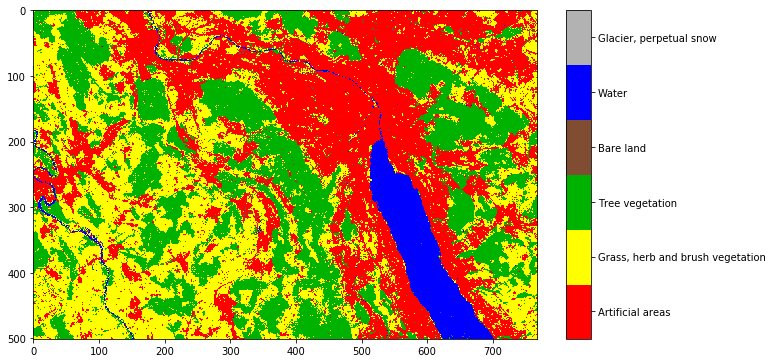

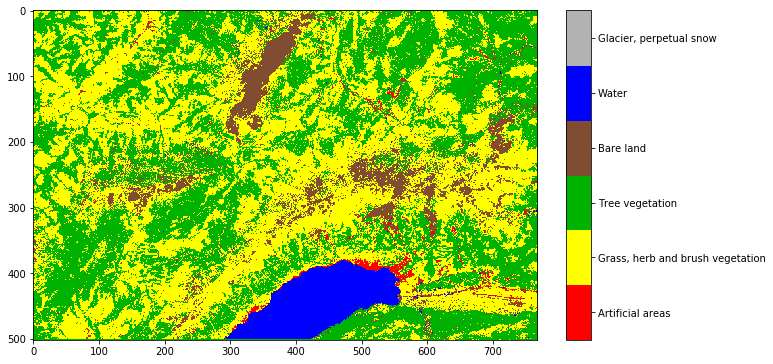

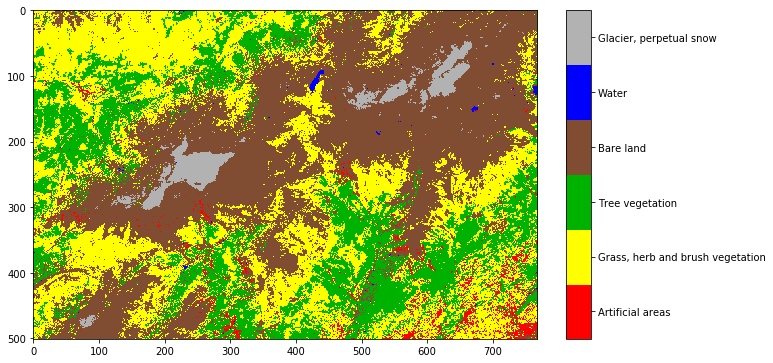

Time series


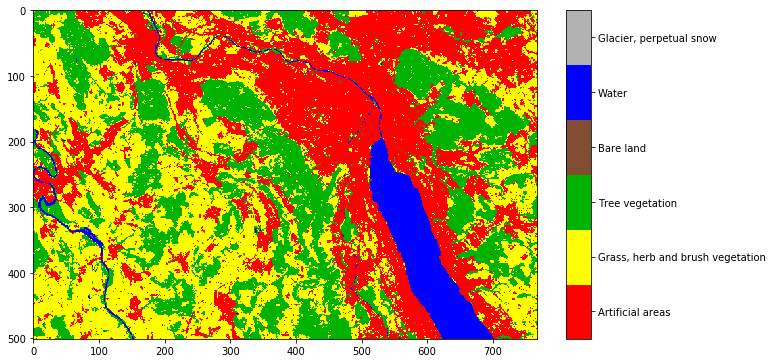

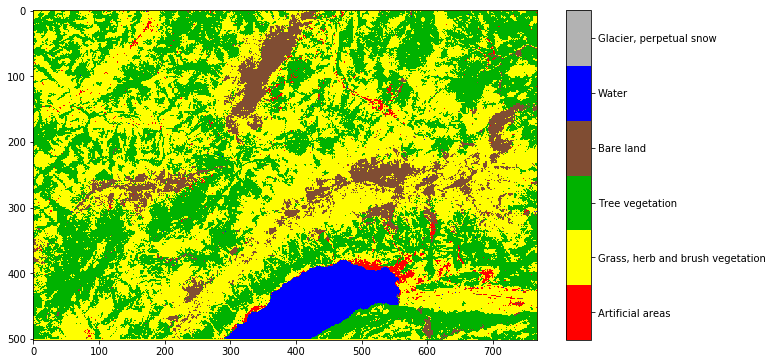

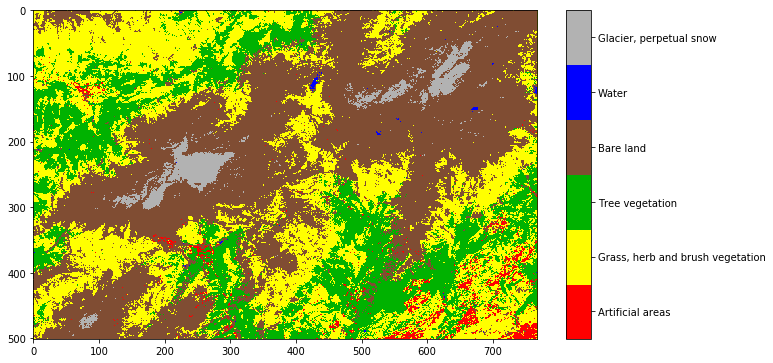

Time series-spatial
Summary statistics (n Samples: 31050)

83.0 % (OA); 88.5 % (AA); 85.8 % (MA); 0.770 % (kappa).

0: 86.37 % (UA) n Class: 3770; 79.63 % (PA) n Ref: 4089)
1: 76.88 % (UA) n Class: 11847; 84.13 % (PA) n Ref: 10826)
2: 84.23 % (UA) n Class: 8677; 82.83 % (PA) n Ref: 8824)
3: 88.80 % (UA) n Class: 5462; 83.08 % (PA) n Ref: 5838)
4: 97.53 % (UA) n Class: 1013; 88.85 % (PA) n Ref: 1112)
5: 97.15 % (UA) n Class: 281; 75.62 % (PA) n Ref: 361)



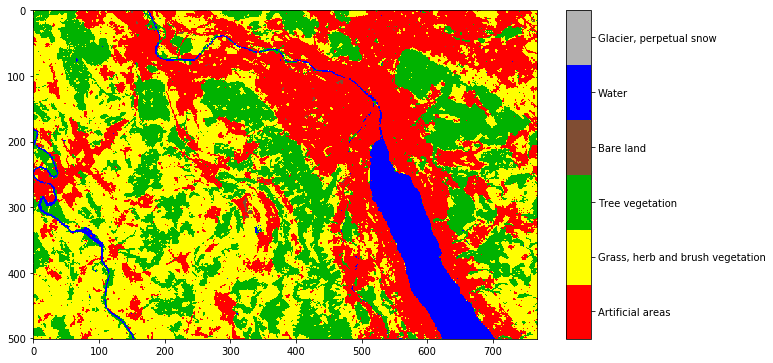

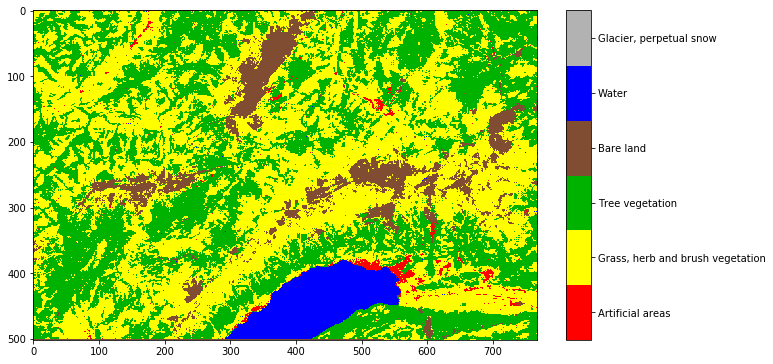

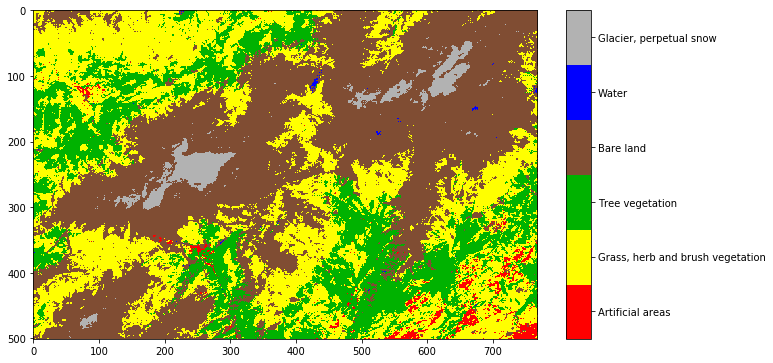

Time series-spatial gaussian filtered


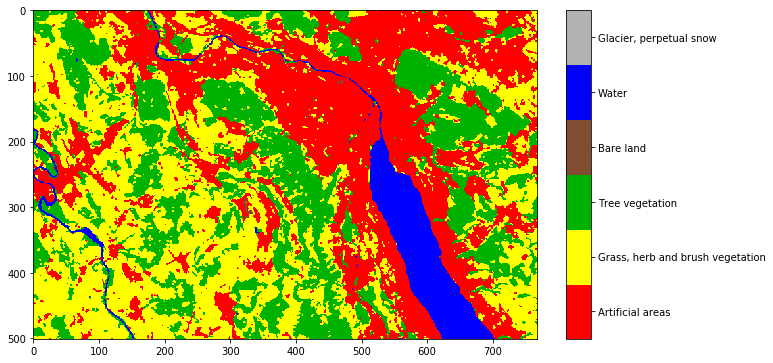

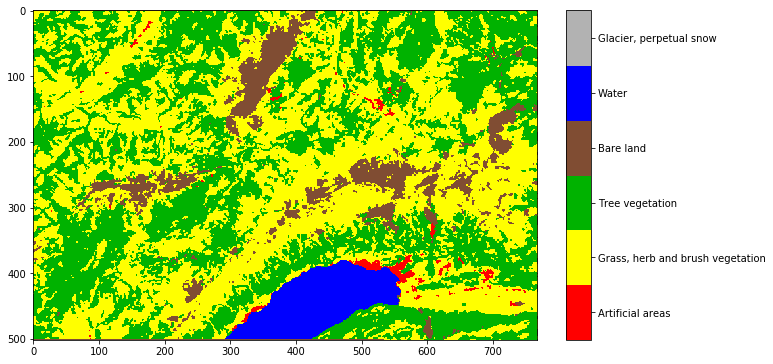

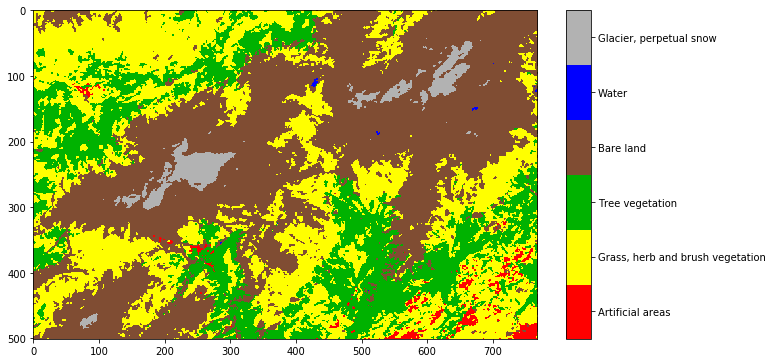

Annual composite


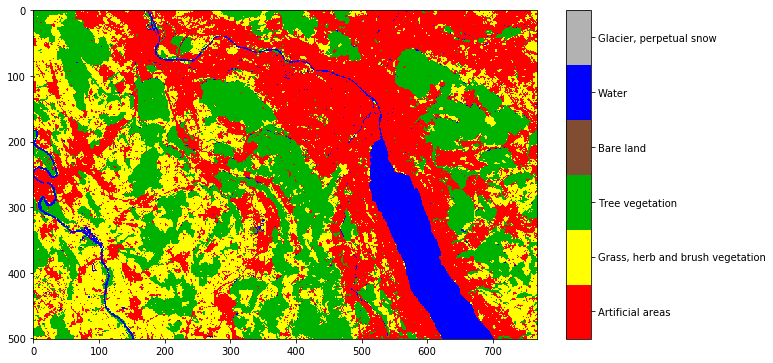

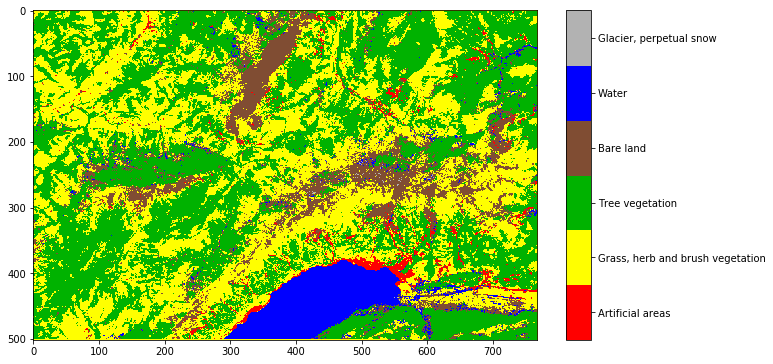

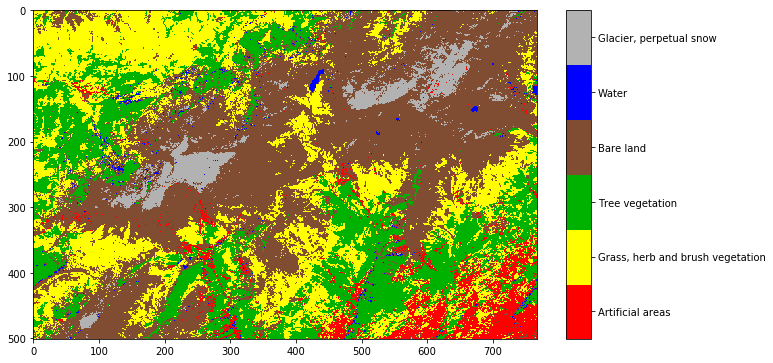

Time series


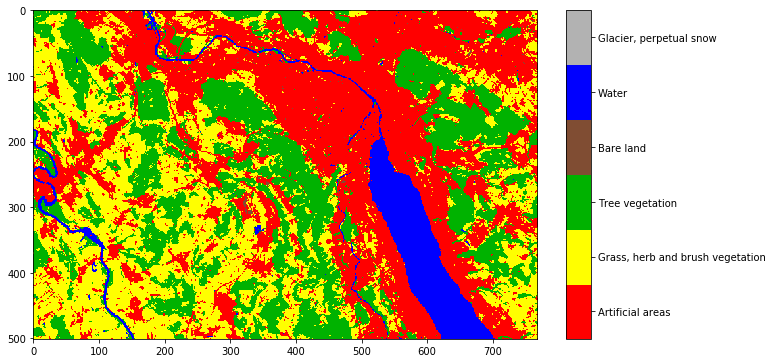

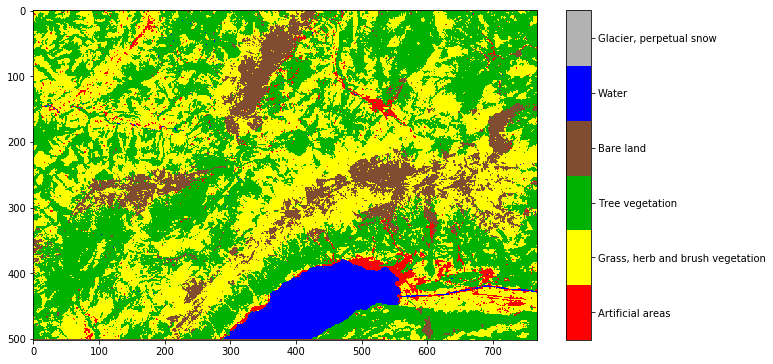

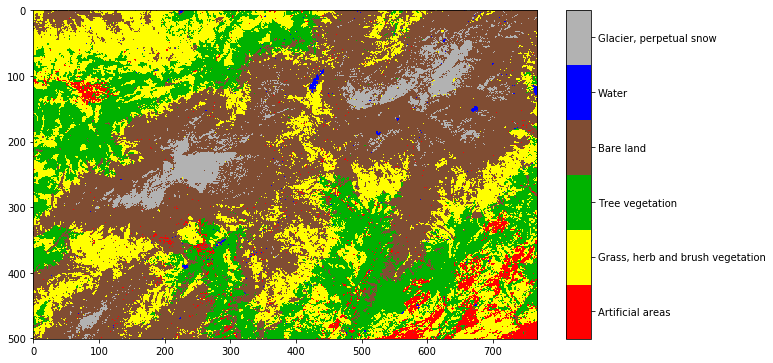

Time series-spatial
Summary statistics (n Samples: 31050)

83.1 % (OA); 82.6 % (AA); 82.8 % (MA); 0.773 % (kappa).

0: 78.79 % (UA) n Class: 4573; 88.59 % (PA) n Ref: 4067)
1: 82.89 % (UA) n Class: 10099; 77.42 % (PA) n Ref: 10813)
2: 83.44 % (UA) n Class: 9407; 86.71 % (PA) n Ref: 9052)
3: 85.18 % (UA) n Class: 5505; 83.12 % (PA) n Ref: 5641)
4: 91.30 % (UA) n Class: 1138; 90.27 % (PA) n Ref: 1151)
5: 74.09 % (UA) n Class: 328; 74.54 % (PA) n Ref: 326)



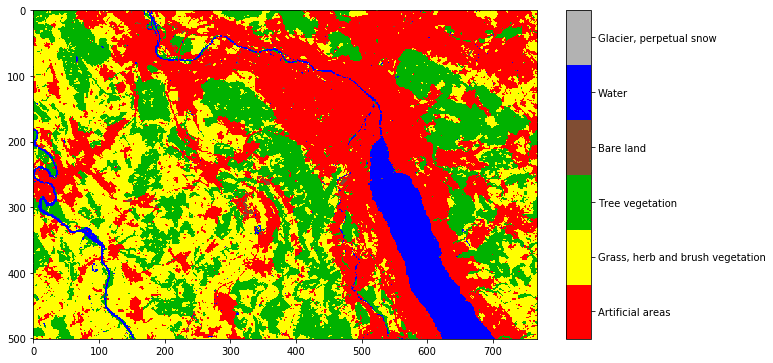

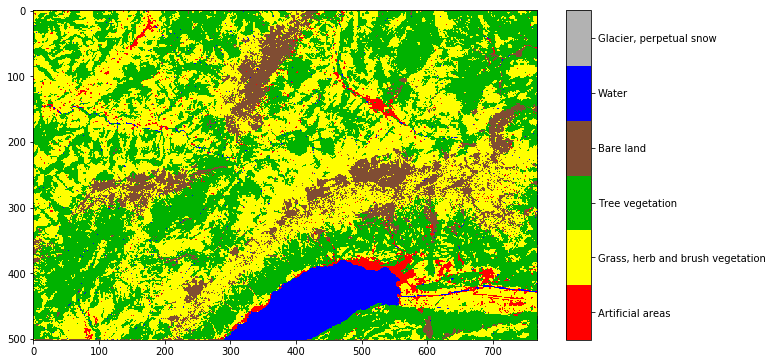

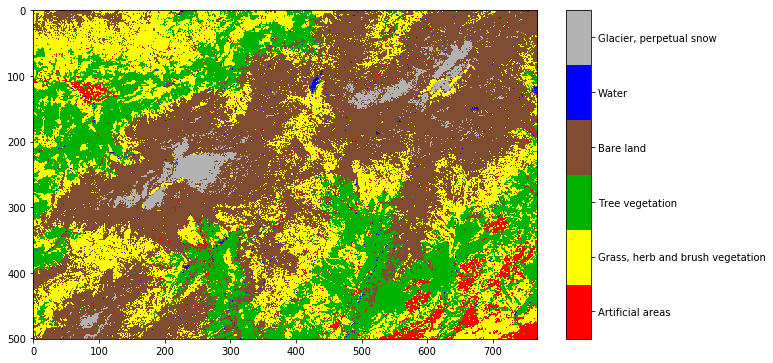

Time series-spatial gaussian filtered


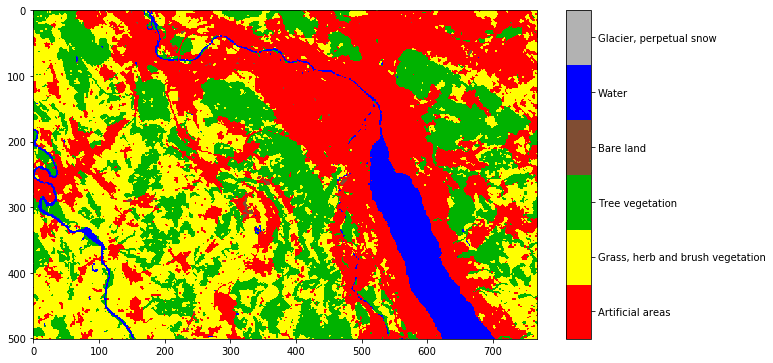

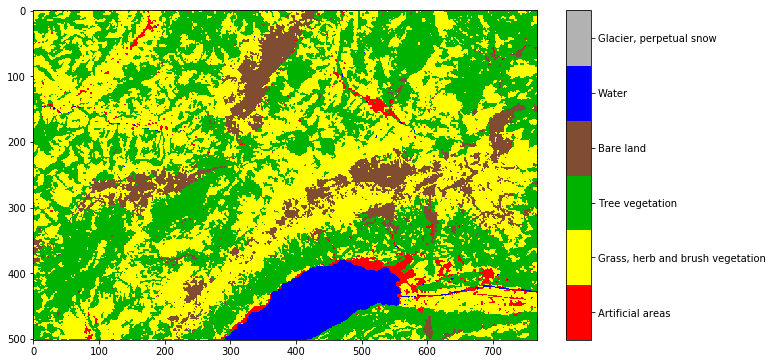

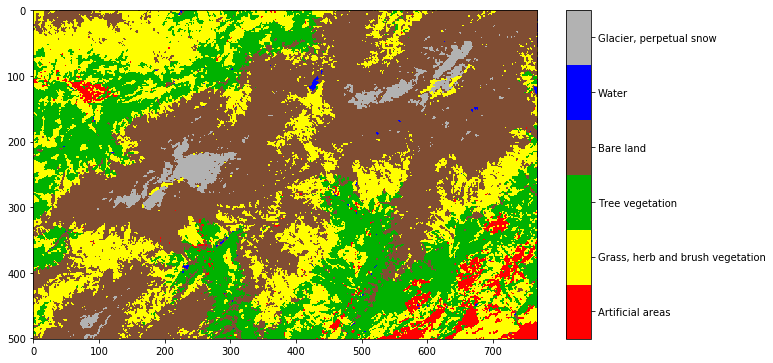

Annual composite


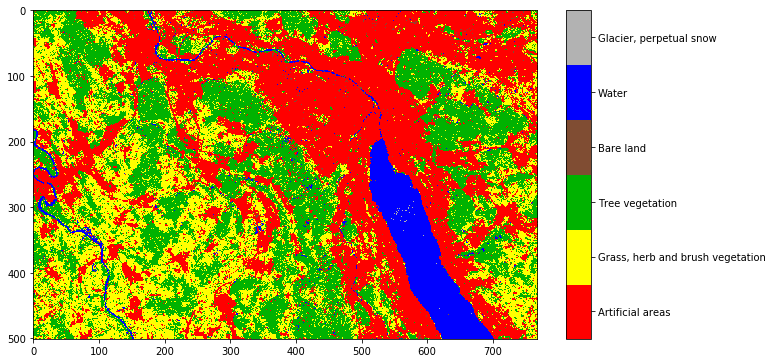

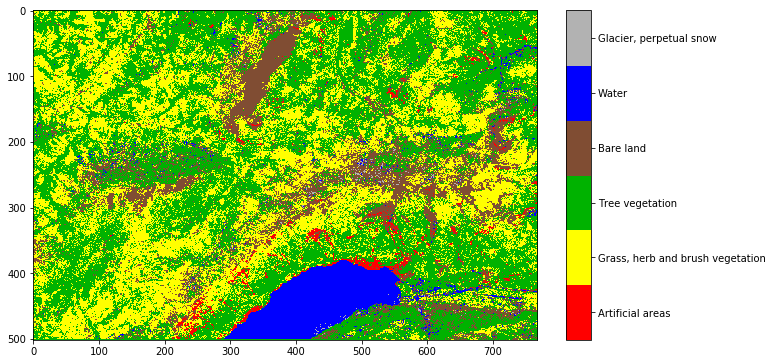

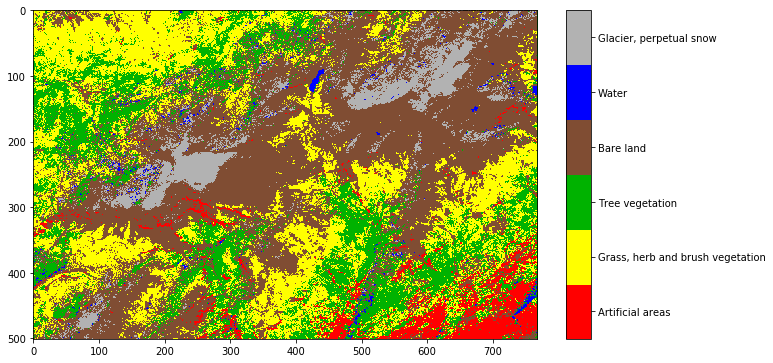

Time series


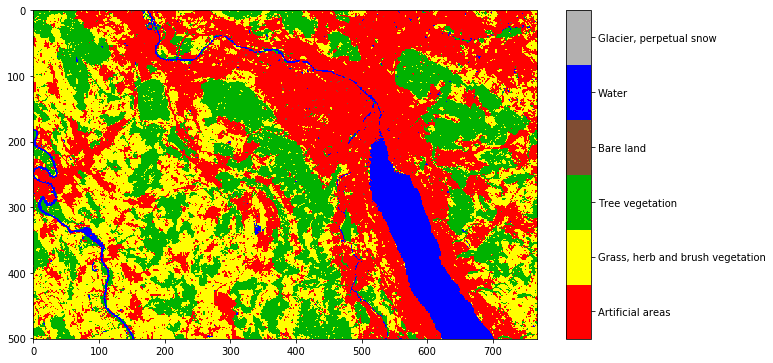

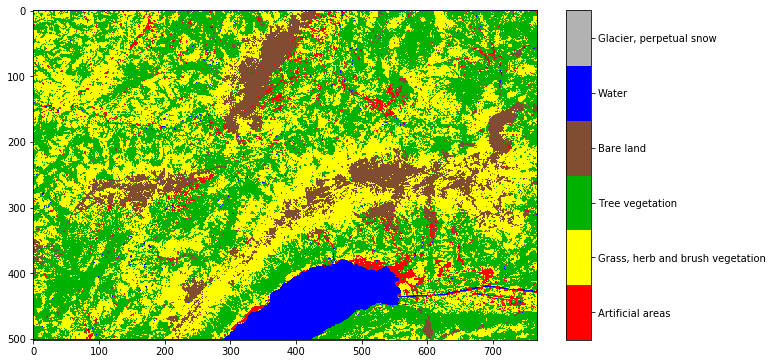

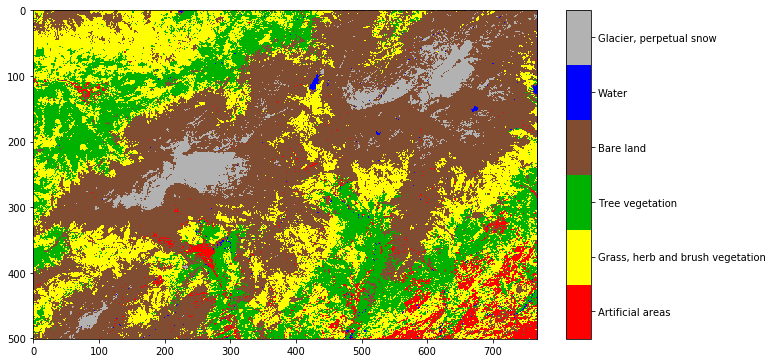

Time series-spatial
Summary statistics (n Samples: 31050)

72.4 % (OA); 70.6 % (AA); 71.5 % (MA); 0.632 % (kappa).

0: 73.30 % (UA) n Class: 4595; 82.33 % (PA) n Ref: 4091)
1: 68.92 % (UA) n Class: 10413; 66.46 % (PA) n Ref: 10799)
2: 71.99 % (UA) n Class: 8490; 68.66 % (PA) n Ref: 8902)
3: 79.44 % (UA) n Class: 5575; 77.58 % (PA) n Ref: 5709)
4: 86.50 % (UA) n Class: 1244; 87.98 % (PA) n Ref: 1223)
5: 43.25 % (UA) n Class: 733; 97.24 % (PA) n Ref: 326)



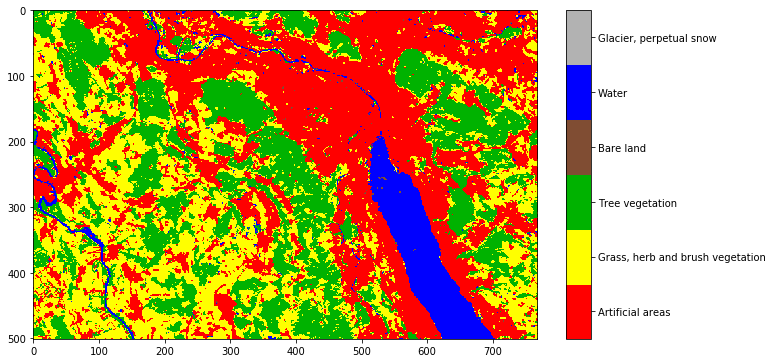

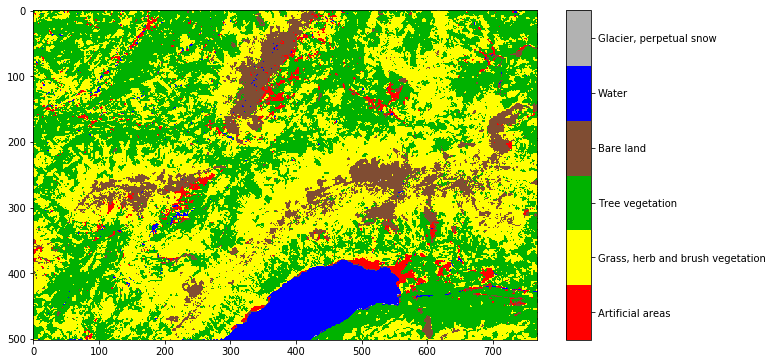

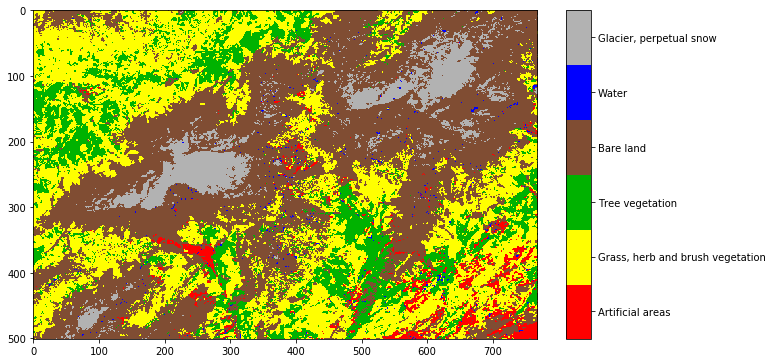

Time series-spatial gaussian filtered


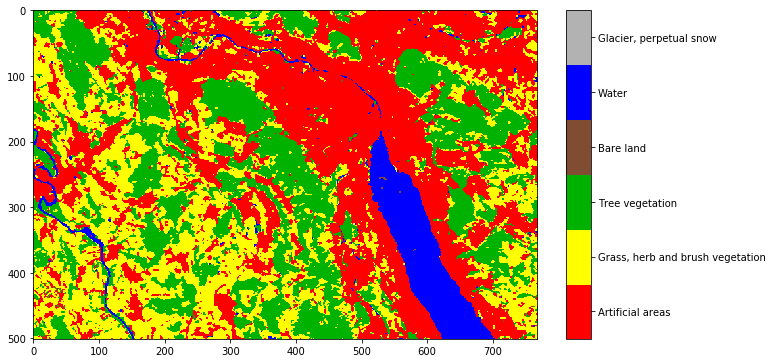

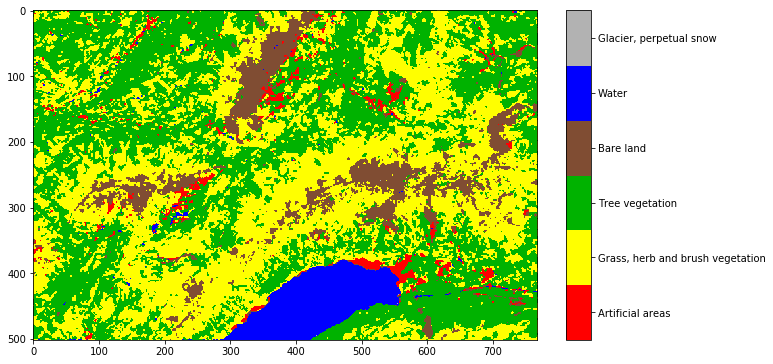

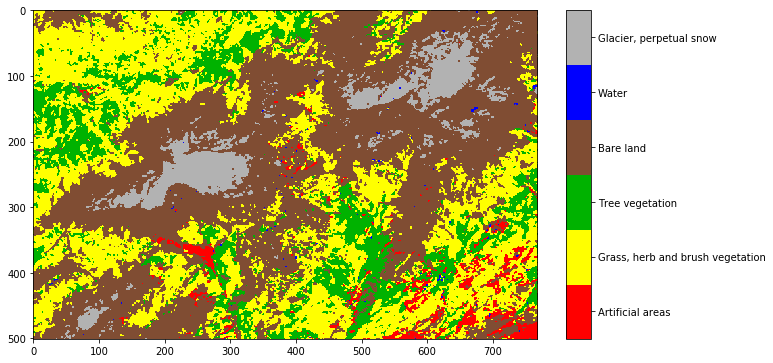

In [5]:
rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
seasons = ['spring','summer','autumn']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ac = bands
features_sc = [f'{band}_{season}' for band in bands for season in seasons]
features_t = [f'midcenter_{band}_{coef}' for band in bands for coef in coefficients]
features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

# split between training and testing data
test_size = 0.3

# define filter used for gaussian filtering
gaussian_kernel3 = np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

# define classifiers
classifiers = {}
classifiers['rf'] = RandomForestClassifier(n_estimators=100,class_weight='balanced')
classifiers['svm'] = svm.SVC(C=1000, gamma='scale', decision_function_shape='ovo', class_weight='balanced')
classifiers['dnn'] = DeepNeuralNetwork()

# container for best working classifiers and their overall accuracy
best_working = {}
def update_best_working(clf,method,candidate):
    can = copy.deepcopy(candidate)
    best_so_far = best_working.get(f'{clf}_{method}',False)
    if not best_so_far:
        best_working[f'{clf}_{method}'] = can
    else:
        if best_so_far[1].score()<can[1].score():
            best_working[f'{clf}_{method}'] = can
            
    # end of update best working classifier function

# data container and function to add data to it
data = []

# define number of iterations
n_iterations = 10

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    # splitting data (using a different split for each iteration)
    train_acomp, test_acomp = train_test_split(data_acomp, test_size=test_size)
    # train_scomp, test_scomp = train_test_split(data_scomp, test_size=test_size)
    train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        
    for clf_key in classifiers.keys():
        
        clf  = classifiers[clf_key]
        
        # ac (annual composite)
        error_matrix, run_time, trained_clf = train_validate_classifier(clf,train_acomp,test_acomp,features_ac,label)
        data.append((clf_key,'ac',test_size,run_time,error_matrix.accuracy_metrics()))
        update_best_working(clf_key,'ac',(trained_clf,error_matrix))
        print(f'{clf_key}-ac',end=' ')
        
        # t (time series)
        error_matrix, run_time, trained_clf = train_validate_classifier(clf,train_coefs,test_coefs,features_t,label)
        data.append((clf_key,'t',test_size,run_time,error_matrix.accuracy_metrics()))
        update_best_working(clf_key,'t',(trained_clf,error_matrix))
        print(f'{clf_key}-t',end=' ')
        
        # ts (time series-spatial)
        error_matrix, run_time, trained_clf = train_validate_classifier(clf,train_coefs,test_coefs,features_ts,label)
        data.append((clf_key,'ts',test_size,run_time,error_matrix.accuracy_metrics()))
        update_best_working(clf_key,'ts',(trained_clf,error_matrix))
        print(f'{clf_key}-ts',end=' ')
        
    print('')
    
d = {
    'classifier': [entry[0] for entry in data],
    'method': [entry[1] for entry in data],
    'testsize': [f'{entry[2]:.2f}' for entry in data],
    'runtime': [entry[3] for entry in data],
    'OA': [entry[4]['OA'] for entry in data],
    'AA': [entry[4]['AA'] for entry in data],
    'MA': [entry[4]['MA'] for entry in data],
    'Kappa': [entry[4]['Kappa'] for entry in data],
}
df = pd.DataFrame(data=d)
df.to_csv(f'{path}classifier_comparison_as{yearAS}.csv', encoding='utf-8', index=False)
print(df.groupby(['classifier','method'])[('OA','AA','MA','Kappa')].mean())

for clf_key in classifiers.keys():
    
    print('Annual composite')
    trained_clf, error_matrix = best_working[f'{clf_key}_ac']
    error_matrix.write2latex(f'{path}{clf_key}_ac_as{yearAS}')
    for roi in rois:
        fname = f'{path_comp}annual_composite_{roi}_{collection_year(roi,yearAS)}.tif'
        composite_classified, geotransform, epsg = classify(trained_clf,fname,spatial=False)
        save_geotiff(composite_classified,geotransform,epsg,f'{path}{clf_key}_ac_{roi}_as{yearAS}')
        plot(composite_classified)
    
    print('Time series')      
    trained_clf, error_matrix = best_working[f'{clf_key}_t']
    error_matrix.write2latex(f'{path}{clf_key}_t_as{yearAS}')
    for roi in rois:
        fname = f'{path_coef}coefficients_{roi}_{collection_year(roi,yearAS)}.tif'
        coefficients_classified, geotransform, epsg = classify(trained_clf,fname,spatial=False)
        save_geotiff(coefficients_classified,geotransform,epsg,f'{path}{clf_key}_t_{roi}_as{yearAS}')
        plot(coefficients_classified)
    
    print('Time series-spatial')
    trained_clf, error_matrix = best_working[f'{clf_key}_ts']
    error_matrix.print_summary()
    error_matrix.write2latex(f'{path}{clf_key}_ts_as{yearAS}')
    for roi in rois:
        fname = f'data/coefficients/coefficients_{roi}_{collection_year(roi,yearAS)}.tif'    
        coefficients_classified, geotransform, epsg = classify(trained_clf,fname,spatial=True)
        save_geotiff(coefficients_classified,geotransform,epsg,f'{path}{clf_key}_ts_{roi}_as{yearAS}')
        plot(coefficients_classified)
    
    print('Time series-spatial gaussian filtered')
    for roi in rois:
        classified_ts, geotransform, epsg = geotiff_to_datacube(f'{path}{clf_key}_ts_{roi}_as{yearAS}.tif')
        classified_ts_gf = gaussian_filter(classified_ts,3)
        save_geotiff(classified_ts_gf[:,:,0],geotransform,epsg,f'{path}{clf_key}_tsgf_{roi}_as{yearAS}')
        plot(classified_ts_gf[:,:,0]) 

In [12]:
class DeepNeuralNetwork():
    
    def __init__(self):
        self.trained = False
        self.enc = OneHotEncoder(categories='auto')
        self.model = False
        self.input_dim = 0
        self.output_dim = 0
        
        # end of init method
    
    def fit(self, X_train, y_train):
        
        sample_weights = class_weight.compute_sample_weight('balanced', y_train)
        
        # one hot encoding data
        y_train_onehot = np.asarray(y_train)
        self.enc.fit(y_train_onehot.reshape(-1,1))
        y_train_onehot = self.enc.transform(y_train_onehot.reshape(-1,1)).todense()
        
        # getting input and output dimension of data
        self.input_dim = len(X_train.columns)
        self.output_dim = y_train_onehot.shape[1]
        # 400 200 100 100 6
        # setting up model
        self.model = keras.Sequential([
            keras.layers.Dense(800, input_dim=self.input_dim, activation=tf.nn.tanh),
            keras.layers.Dense(400, activation=tf.nn.tanh),
            keras.layers.Dense(200, activation=tf.nn.tanh),
            keras.layers.Dense(50, activation=tf.nn.tanh),
            keras.layers.Dense(self.output_dim, activation=tf.nn.softmax)
        ])
        opt = keras.optimizers.Adam(lr=0.001)
        self.model.compile(
          optimizer=opt,
          loss='categorical_crossentropy',
          metrics = ["accuracy"]
        )
        
        # training deep neural network
        batchsize = 256
        for i in range(6):
            # print(batchsize)
            self.model.fit(X_train, y_train_onehot, epochs=20, batch_size=batchsize, sample_weight=sample_weights, verbose=1)
            batchsize *= 2
        
        self.trained = True
        # end of fit method
    
    def set_model(self,model):
        
        self.model = model
        self.trained = True
        
    def __deepcopy__(self,memo):
        # model_copy = tf.keras.models.clone_model(self.model)
        
        self.model.save_weights('model_weights.h5')
        model_copy = keras.Sequential([
            keras.layers.Dense(800, input_dim=self.input_dim, activation=tf.nn.tanh),
            keras.layers.Dense(400, activation=tf.nn.tanh),
            keras.layers.Dense(200, activation=tf.nn.tanh),
            keras.layers.Dense(50, activation=tf.nn.tanh),
            keras.layers.Dense(self.output_dim, activation=tf.nn.softmax)
        ])
        model_copy.compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ["accuracy"]
        )
        model_copy.load_weights('model_weights.h5')
        dnn_copy  = DeepNeuralNetwork()
        dnn_copy.set_model(model_copy)
        return dnn_copy
        

    def predict(self, X_test):
        
        if self.trained:
            y_pred = np.argmax(self.model.predict(X_test), axis=1)
        
        return y_pred
        # end of predict method

rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
seasons = ['spring','summer','autumn']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ac = bands
features_sc = [f'{band}_{season}' for band in bands for season in seasons]
features_t = [f'midcenter_{band}_{coef}' for band in bands for coef in coefficients]
features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

# split between training and testing data
test_size = 0.3


    
# splitting data (using a different split for each iteration)
train_acomp, test_acomp = train_test_split(data_acomp, test_size=test_size)
# train_scomp, test_scomp = train_test_split(data_scomp, test_size=test_size)
train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        


# define classifiers
clf = svm.SVC(C=1000,gamma='scale', decision_function_shape='ovo', class_weight='balanced')
clf = DeepNeuralNetwork()
    
# ac (annual composite)
# error_matrix, run_time, trained_clf = train_validate_classifier(clf,train_acomp,test_acomp,features_ac,label)
# error_matrix.print_summary()
        
# t (time series)
# error_matrix, run_time, trained_clf = train_validate_classifier(clf,train_coefs,test_coefs,features_t,label)
# error_matrix.print_summary()
        
# ts (time series-spatial)
error_matrix, run_time, trained_clf = train_validate_classifier(clf,train_coefs,test_coefs,features_ts,label)
error_matrix.print_summary()

Epoch 1/20
72450/72450 [==============================] - 18s 243us/sample - loss: 0.7448 - acc: 0.6077
Epoch 2/20
72450/72450 [==============================] - 17s 235us/sample - loss: 0.7925 - acc: 0.5867
Epoch 3/20
72450/72450 [==============================] - 17s 237us/sample - loss: 0.8701 - acc: 0.5408
Epoch 4/20
72450/72450 [==============================] - 17s 240us/sample - loss: 1.2830 - acc: 0.4495
Epoch 5/20
72450/72450 [==============================] - 17s 239us/sample - loss: 0.9000 - acc: 0.5398
Epoch 6/20
72450/72450 [==============================] - 18s 242us/sample - loss: 0.9117 - acc: 0.5358
Epoch 7/20
72450/72450 [==============================] - 18s 242us/sample - loss: 0.8600 - acc: 0.5667
Epoch 8/20
72450/72450 [==============================] - 15s 208us/sample - loss: 0.8087 - acc: 0.5624
Epoch 9/20
72450/72450 [==============================] - 6s 80us/sample - loss: 0.7933 - acc: 0.5714
Epoch 10/20
72450/72450 [==============================] - 6s 83us

                          OA         AA         MA     Kappa      AvgUA  \
method classifier                                                         
ac     dnn         68.764895  65.973446  67.369171  0.587077  65.973446   
       rf          77.574235  83.406702  80.490469  0.696257  83.406702   
       svm         75.163607  73.215164  74.189385  0.669263  73.215164   
t      dnn         76.892754  74.730986  75.811870  0.692569  74.730986   
       rf          81.395169  85.654950  83.525060  0.747866  85.654950   
       svm         79.183897  76.278385  77.731141  0.722341  76.278385   
ts     dnn         70.991304  69.755591  70.373447  0.615093  69.755591   
       rf          82.964895  87.941419  85.453157  0.768626  87.941419   
       svm         81.644767  79.785469  80.715118  0.754895  79.785469   

                       AvgPA     runtime  
method classifier                         
ac     dnn         76.635245   72.522071  
       rf          78.822294    9.882971  
  

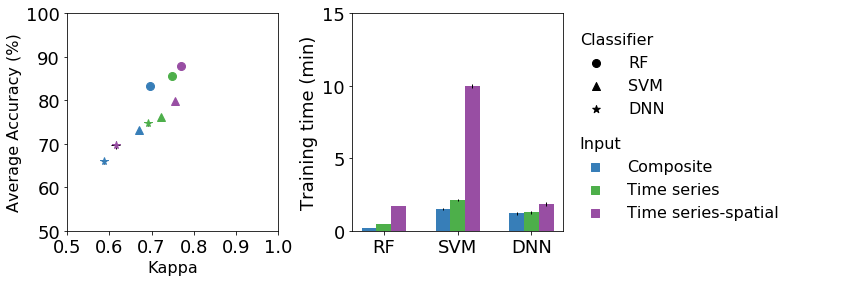

In [9]:
# plotting the classifier comparison

# chose 2 accuracy metrics
am_x = 'Kappa'
am_y = 'AA'


df = pd.read_csv(f'data/classification_data/classifier_comparison_as{yearAS}.csv')
df = df.dropna()

grouped = df.groupby(['method','classifier'])
print(grouped.mean()[['OA','AA','MA','Kappa','AvgUA','AvgPA','runtime']])
print(grouped.std()[['OA','AA','MA','Kappa','AvgUA','AvgPA']])
means = grouped.mean().to_dict()
stds = grouped.std().to_dict()


fig, axes = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(14)
plt.subplots_adjust(wspace=0.35)
axes = axes.ravel()

ax = axes[0]
fontsize = 16
plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })


classifiers = ['rf','svm','dnn']
markers = ['o','^','*']


methods = ['ac','t','ts']
inputs = ['Composite', 'Time series', 'Time series-spatial']
colors = ['#377eb8','#4daf4a','#984ea3']

# classifiers (shape) for legend
cpoints = []
for i, clf in enumerate(classifiers):
    cpoint = ax.scatter(
        means[am_x][('ac',clf)],
        means[am_y][('ac',clf)],
        marker=markers[i],
        color='k',
        label=clf,
        s=1,
    )
    cpoints.append(cpoint)
    
# methods (color) for legend
mpoints = []
for i, method in enumerate(methods):
    mpoint = ax.scatter(
        means[am_x][(method,'rf')],
        means[am_y][(method,'rf')],
        marker='s',
        color=colors[i],
        label=inputs[i],
        s=1,
    )
    mpoints.append(mpoint)

# print accuracy data for classifiers and methods
for iclf, clf in enumerate(classifiers):
    for im, m in enumerate(methods):
        key = (m,clf)
        ax.errorbar(
            x=means[am_x][key],
            xerr=stds[am_x][key],
            y=means[am_y][key],
            yerr=stds[am_y][key],
            ms=8,
            c=colors[im],
            marker=markers[iclf],
            ecolor='k',
            elinewidth=1,
        )


xlower, xupper = (0.5,1)
xlimits = [xlower,xupper]
xticks = np.linspace(xlower,xupper,6)
xlabels = [f'{xtick:.1f}' for xtick in list(xticks)]
ax.set_xlim(xlimits)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

ylower, yupper = (50,100)
ylimits = [ylower,yupper]
yticks = np.arange(ylower,yupper+1,10)
ylabels = [f'{ytick:.0f}' for ytick in list(yticks)]
ax.set_ylim(ylimits)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)


ax.set_xlabel('Kappa', fontdict={'fontsize': fontsize})
ax.set_ylabel('Average Accuracy (%)', fontdict={'fontsize': fontsize})

legend_xpos = 2.9

leg1 = ax.legend(
    cpoints,
    [clf.upper() for clf in classifiers],
    title='Classifier',
    bbox_to_anchor=(legend_xpos, 0.98),
    frameon=False,
    markerscale=8,
    handletextpad=1,
)
leg1._legend_box.align = "left"

leg2 = ax.legend(
    mpoints,
    inputs,
    title='Input',
    loc='center',
    bbox_to_anchor=(legend_xpos, 0.24),
    frameon=False,
    markerscale=8,
    handletextpad=1,
)
leg2._legend_box.align = "left"
ax.add_artist(leg1)



# change axis to right axis for runtime plot
ax = axes[1]


mean_runtime_data = []
std_runtime_data = []

for m in methods:
    runtime_mean_method = [means['runtime'].get((m,clf)) for clf in classifiers]
    mean_runtime_data.append(runtime_mean_method)
    runtime_std_method = [stds['runtime'].get((m,clf)) for clf in classifiers]
    std_runtime_data.append(runtime_std_method)


for i, (mean, std) in enumerate(zip(mean_runtime_data,std_runtime_data)):
    
    # rescaling to minutes
    mean = [m/60. for m in mean]
    std = [s/60. for s in std]
   
    
    wbar = 0.2
    xpos = [x-wbar+i*wbar for x in range(len(classifiers))]
     
    ax.bar(
        x=xpos,
        height=mean,
        yerr=std,
        width=0.2,
        color=colors[i],
        error_kw={'ecolor':'k','elinewidth':1},
    )
    

    
yticks = np.arange(0,16,5)
yticklabels = [f'{ytick:.0f}' for ytick in list(yticks)]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)


# ax.set_ylabel('Runtime (min)',rotation=270,labelpad=20)
ax.set_ylabel('Training time (min)')
ax.set_xticks(range(3))
ax.set_xticklabels([clf.upper() for clf in classifiers])
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

axes[2].axis('off')

plt.savefig('plots/classifier_comparison',dpi=300,bbox_inches='tight')
plt.show()

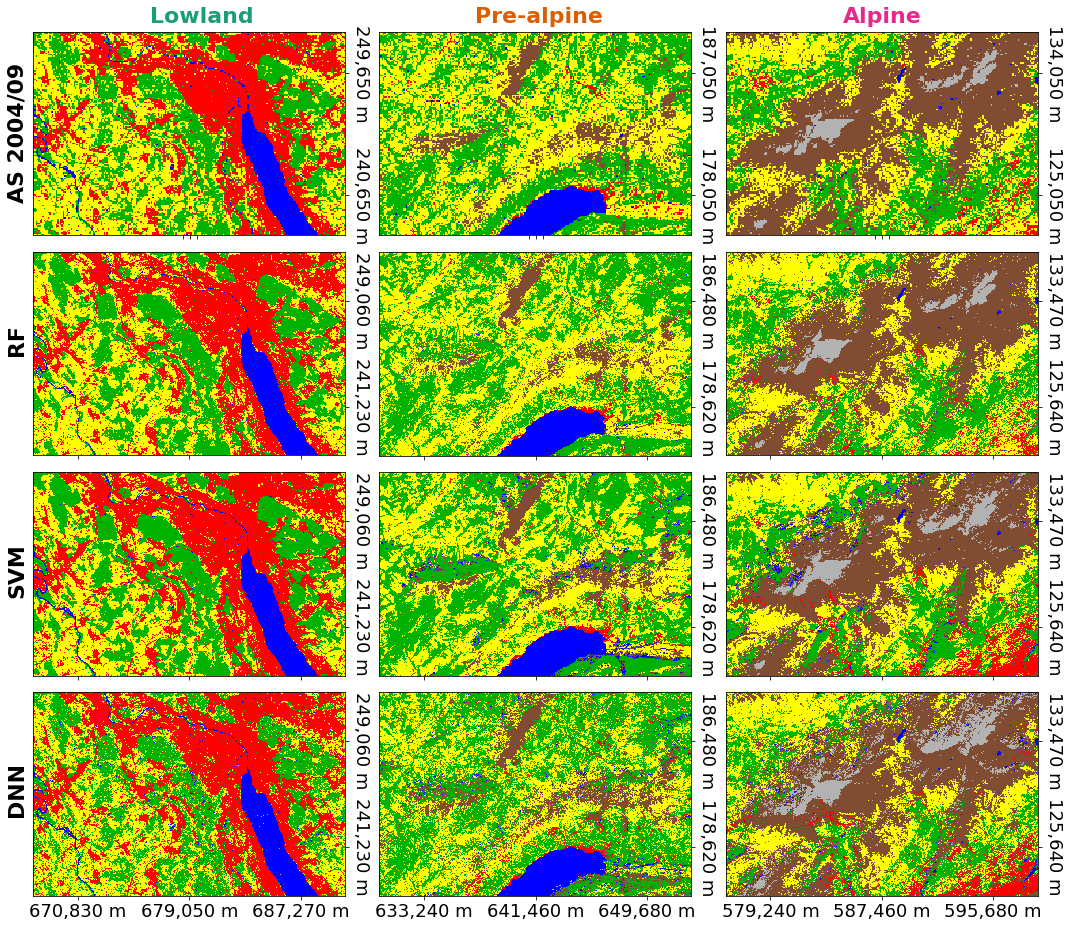

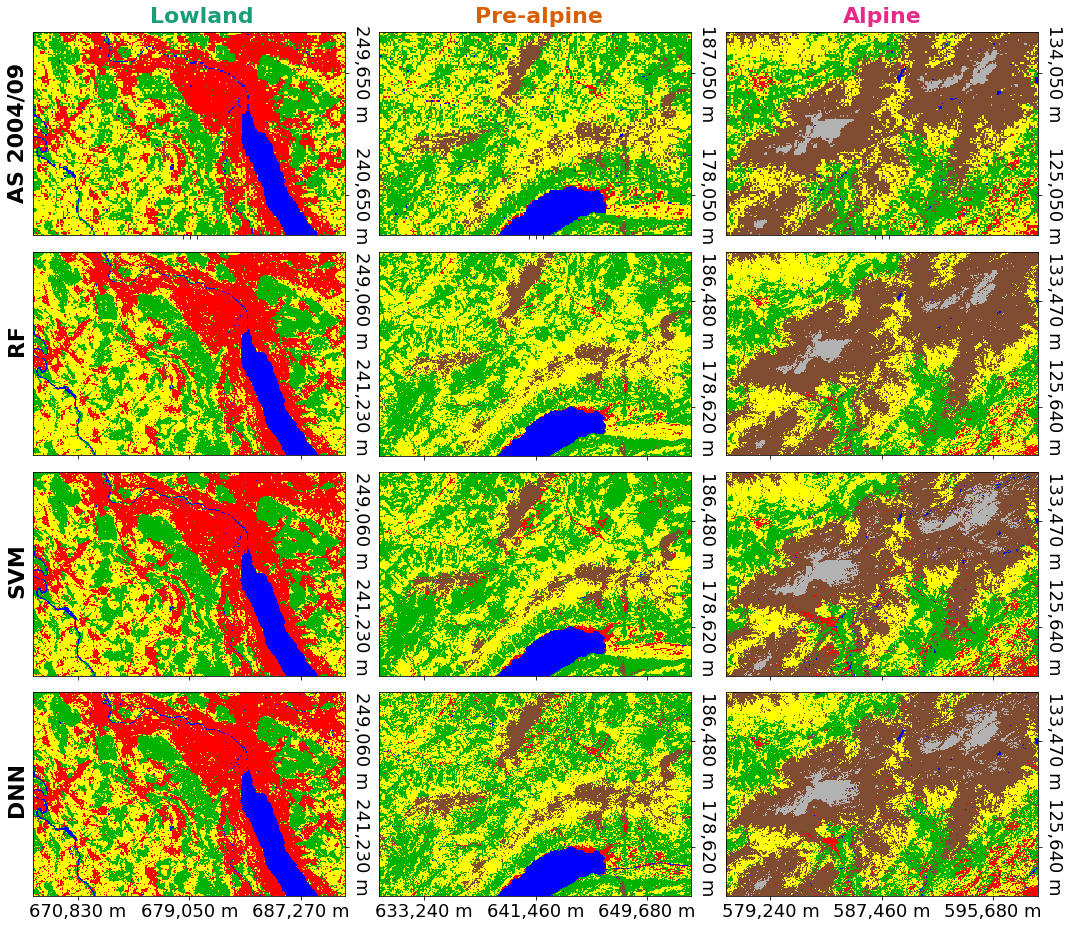

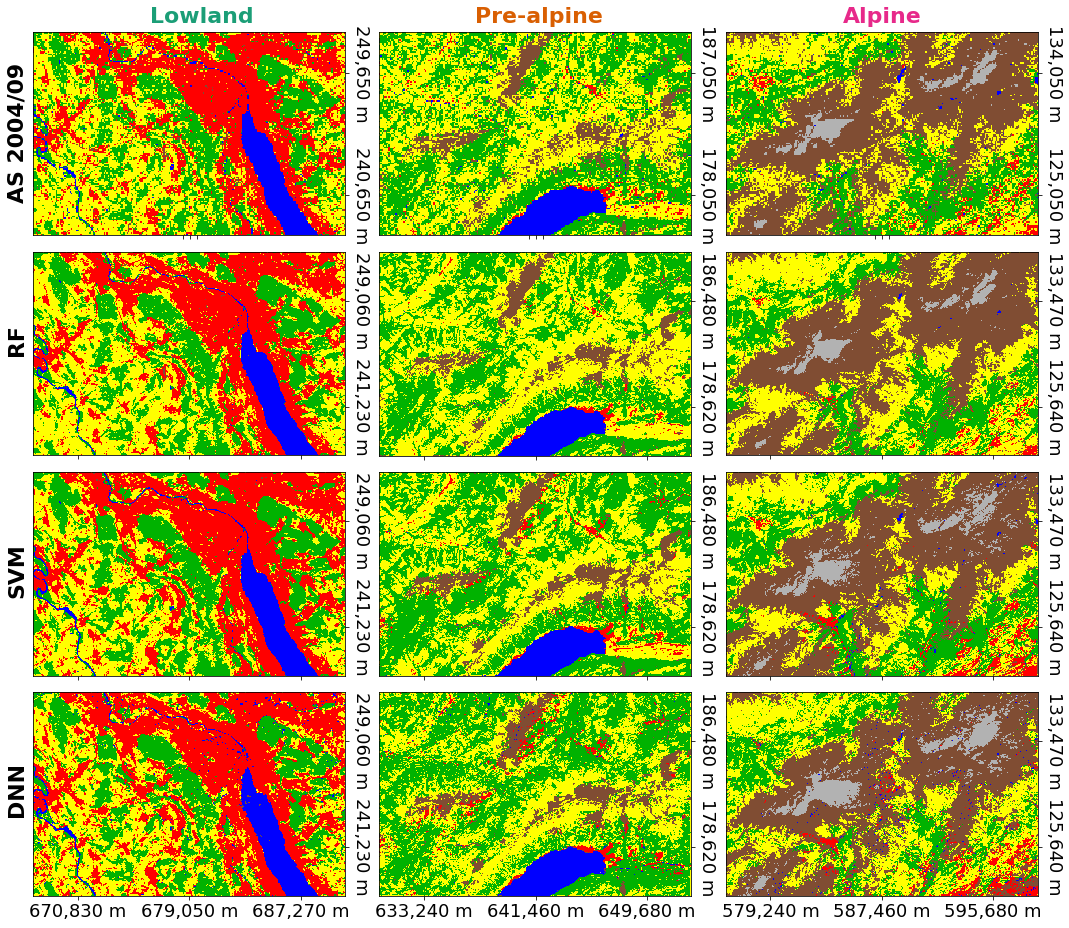

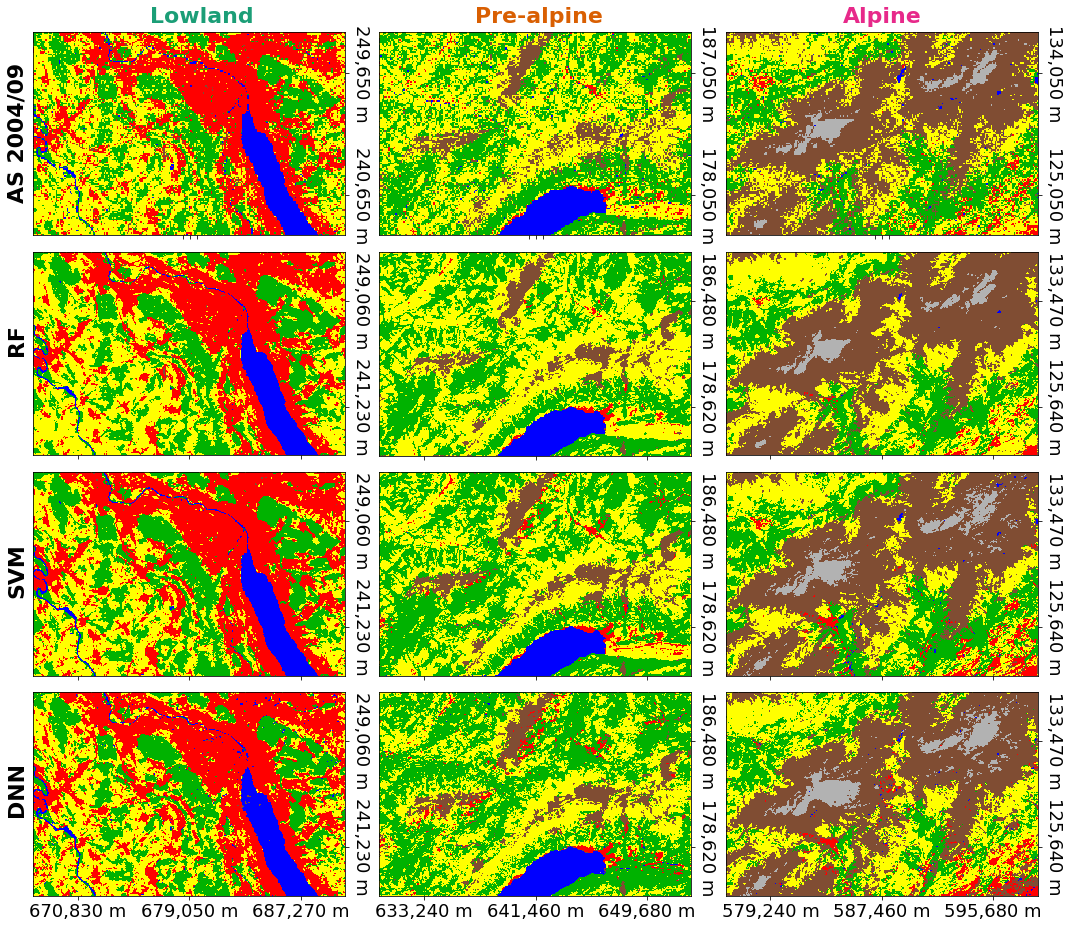

In [144]:
classifiers = ['rf','svm','dnn']
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
methods = ['ac','t','ts','tsgf']
yearAS = 2004

fontsize_title = 22
fontsize = 18

for m in methods:
    fig, axs = plt.subplots(4,3, figsize=(18,16), facecolor='w', edgecolor='k') # w h
    plt.rcParams.update({'font.size': fontsize})
    fig.subplots_adjust(hspace=0.05, wspace=0.11)
    axs = axs.ravel()
    
    # plot validation (arealstatistik)
    for i, roi in enumerate(rois):
            ax = axs[i]
            fname = f'data/arealstatistik/validation_{roi}_as{yearAS}.tif'
            plot_classification(ax,fname,False,True)
    
    # plotting results for each classifier
    for i, clf in enumerate(classifiers):
        for j, roi in enumerate(rois):
            
            ax = axs[(i+1)*len(rois)+j]
        
            x_labels = True if i==len(classifiers)-1 else False
            y_labels = True

            fname = f'data/classification_data/{clf}_{m}_{roi}_as{yearAS}.tif'
            plot_classification(ax,fname,x_labels,y_labels)
    
    fig.text(0.255, 0.885, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
    fig.text(0.515, 0.885, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
    fig.text(0.78, 0.885, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')

    fig.text(0.105, 0.79, 'AS 2004/09', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.105, 0.61, 'RF', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.105, 0.41, 'SVM', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.105, 0.22, 'DNN', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

    plt.savefig(f'plots/classification_visual_results_{m}.png', dpi=300, bbox_inches = "tight")

    
from matplotlib.patches import Rectangle
# add annotations
def add_annotation(ax,label,width,height,x,y):
    r = Rectangle((x, y), width, height, edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(r)
    ax.text(x, y, label, fontsize=16)


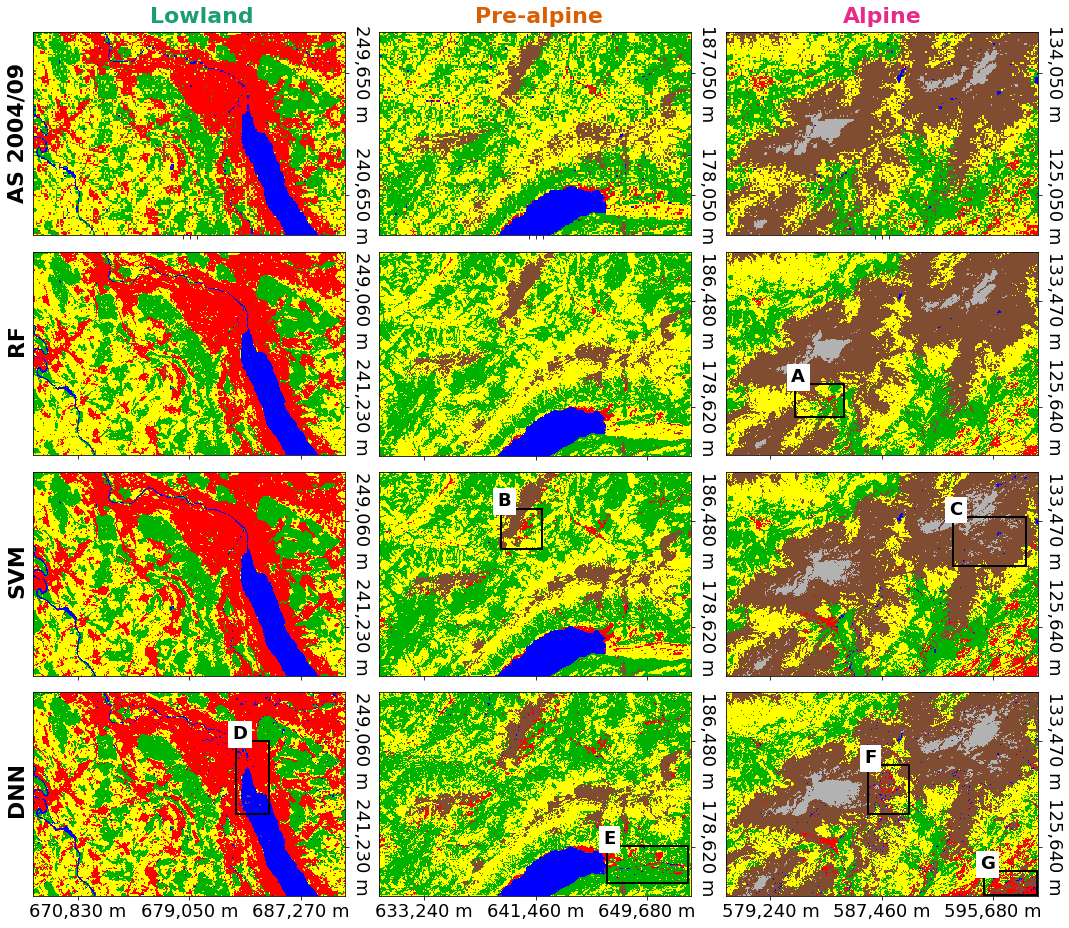

In [28]:
classifiers = ['rf','svm','dnn']
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
yearAS = 2004

fontsize_title = 22
fontsize = 18


fig, axs = plt.subplots(4,3, figsize=(18,16), facecolor='w', edgecolor='k') # w h
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.05, wspace=0.11)
axs = axs.ravel()
    
# plot validation (arealstatistik)
for i, roi in enumerate(rois):
    ax = axs[i]
    fname = f'data/arealstatistik/validation_{roi}_as{yearAS}.tif'
    plot_classification(ax,fname,False,True)
    
# plotting results for each classifier
for i, clf in enumerate(classifiers):
    for j, roi in enumerate(rois):
            
        ax = axs[(i+1)*len(rois)+j]
        
        x_labels = True if i==len(classifiers)-1 else False
        y_labels = True

        fname = f'data/classification_data/{clf}_ts_{roi}_as{yearAS}.tif'
        plot_classification(ax,fname,x_labels,y_labels)
    
fig.text(0.255, 0.885, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
fig.text(0.515, 0.885, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.78, 0.885, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')

fig.text(0.105, 0.79, 'AS 2004/09', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.105, 0.61, 'RF', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.105, 0.41, 'SVM', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.105, 0.22, 'DNN', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)



    

# add annotations
def add_annotation(ax,label,width,height,x,y):
    r = Rectangle((x, y), width, height, edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(r)
    text = ax.text(x-10, y-6, label, fontsize=18, fontweight='bold')
    text.set_bbox(dict(facecolor='white', edgecolor='white', alpha=1))

# rf
add_annotation(axs[5],'A',120,80,170,325)

# svm
add_annotation(axs[7],'B',100,100,300,90)
add_annotation(axs[8],'C',180,120,560,110)

# dnn
add_annotation(axs[9],'D',80,180,500,120)
add_annotation(axs[10],'E',200,90,560,380)
add_annotation(axs[11],'F',100,120,350,180)
add_annotation(axs[11],'G',130,60,635,440)

    
plt.savefig(f'plots/classification_visual_results_ts_annotated.png', dpi=300, bbox_inches = "tight")

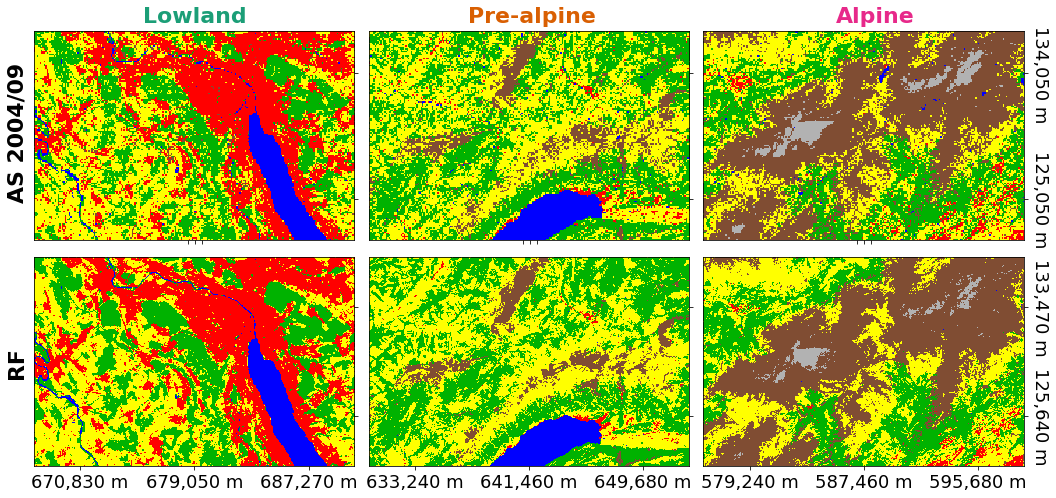

In [11]:
classifier = 'rf'
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']


fontsize_title = 22
fontsize = 18


fig, axs = plt.subplots(2,3, figsize=(18,8), facecolor='w', edgecolor='k') # w h
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.08, wspace=0.0)
axs = axs.ravel()


for i, roi in enumerate(rois):
    ax = axs[i]
        
    x_labels = False
    y_labels = True if i+1==len(rois) else False
        
    fname = f'data/arealstatistik/validation_{roi}_as2004.tif'
    plot_classification(ax,fname,x_labels,y_labels)

for i, roi in enumerate(rois):
    ax = axs[len(rois)+i]
        
    x_labels = True
    y_labels = True if i+1==len(rois) else False
        
    fname = f'data/classification_data/as2004_{roi}_rf_ts.tif'
    plot_classification(ax,fname,x_labels,y_labels)
        
    
fig.text(0.255, 0.895, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
fig.text(0.515, 0.895, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.78, 0.895, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')

fig.text(0.11, 0.705, 'AS 2004/09', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.11, 0.305, 'RF', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'plots/classification_presentation.png', dpi=300, bbox_inches = "tight")

In [10]:
# training size experiment

rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

subsample_sizes = [1,10,100,1000]
test_size = 0.3

# define classifier
clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')

# data container
data = []
def add_data(data,base,users,producers):
    for i, (u,p) in enumerate(zip(users,producers)):
        data.append((i,*base,u,p))

# define number of iterations
n_iterations = 10

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    for s in subsample_sizes:
        
        # splitting data (using a different split and split ratio for each iteration)        
        train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        trainsubsample_coefs = [train_coefs[train_coefs['land_cover']==i].sample(n=s,replace=True) for i in range(6)]
        trainsubsample_coefs = pd.concat(trainsubsample_coefs)
            
        # ts (time series-spatial)
        error_matrix_ts, run_time_ts, _ = train_validate_classifier(clf,trainsubsample_coefs,test_coefs,features_ts,label)
        users_ts = error_matrix_ts.users_accuracies()
        producers_ts = error_matrix_ts.producers_accuracies()
        add_data(data,('rf','ts',s,run_time_ts),users_ts,producers_ts)
            
            
                        
d = {
    'land_cover': [entry[0] for entry in data],
    'classifier': [entry[1] for entry in data],
    'method': [entry[2] for entry in data],
    'ntraining': [entry[3] for entry in data],
    'runtime': [entry[4] for entry in data],
    'UA': [entry[5] for entry in data],
    'PA': [entry[6] for entry in data],
}
       
df = pd.DataFrame(data=d)
df.to_csv(f'{path}training_size_as{yearAS}.csv', encoding='utf-8', index=False)
df.head()


Iteration: 1/10


NameError: name 'data_coefs' is not defined

[1, 10, 100, 1000]
                             UA         PA
land_cover ntraining                      
0          1          27.564117  72.515150
           10         53.819160  79.997919
           100        71.793423  83.071833
           1000       76.684530  84.699182
1          1          42.879398  16.432841
           10         64.387579  40.087167
           100        75.569279  64.031405
           1000       79.265595  72.885183
2          1          48.942854  37.024454
           10         69.442993  76.680189
           100        78.037206  79.744277
           1000       81.441251  81.896387
3          1          49.200856  17.360581
           10         64.665090  68.105024
           100        72.184700  78.665067
           1000       79.717264  83.332934
4          1          44.093794  63.427961
           10         75.637949  84.679003
           100        89.342748  86.927825
           1000       93.101447  89.305892
5          1           8.172240  70

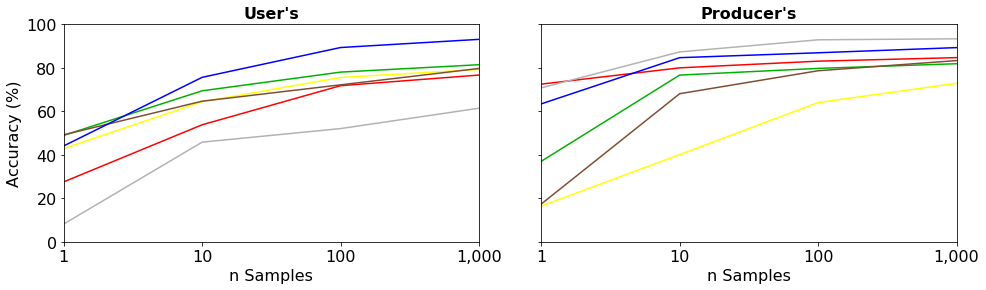

In [5]:
# plot training size experiment

df = pd.read_csv(f'{path}training_size_as{yearAS}.csv')



metrics = ['UA','PA']
classifier = 'rf'
method = 'ts'
subsample_sizes = [1,10,100,1000]
print(subsample_sizes)

classes = ['Artificial areas', 'Grass, herb and brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
hex_colors = ["#FF0000","#FFFF00","#00B200","#804D33",'#0000FF','#B2B2B2']


fig, axes = plt.subplots(1,2,sharey=True)
fig.set_figheight(4)
fig.set_figwidth(16)
plt.subplots_adjust(wspace=0.15)
plt.xscale(value='log')
axes = axes.ravel()

fontsize = 16
plt.rcParams.update({'font.size': fontsize})

df = df[(df['method']==method) & (df['classifier']==classifier)]


print(df.groupby(['land_cover','ntraining']).mean()[['UA','PA']])

    
for j, (class_,color) in enumerate(zip(classes,hex_colors)):
    df_class = df[df['land_cover']==j]
    means = df_class.groupby(['ntraining']).mean()
    y_uas = list(means['UA'])
    y_pas = list(means['PA'])
    
    axes[0].plot(subsample_sizes,y_uas,color=color,label=class_)
    axes[1].plot(subsample_sizes,y_pas,color=color,label=class_)
    

ymin, ymax = (0,100)
yticks = list(range(ymin,ymax+1,20))
xmin, xmax = (1,1000)

for ax in axes:
    ax.set_xscale('log')
    ax.minorticks_off()
    ax.set_ylim([ymin,ymax])
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks,fontdict={'fontsize': fontsize})
    
    ax.set_xlim([subsample_sizes[0],subsample_sizes[-1]])
    ax.set_xticks(subsample_sizes)
    ax.set_xticklabels([f'{s:,}' for s in subsample_sizes],fontdict={'fontsize': fontsize})
    
    ax.set_xlabel('n Samples',fontsize=fontsize,fontweight='normal')
    
    



    
axes[0].set_ylabel('Accuracy (%)',fontsize=fontsize,fontweight='normal')
# axes[1].set_ylabel('Producer\'s accuracy (%)',fontsize=fontsize,fontweight='bold')
axes[1].set_xlabel('n Samples')

axes[0].set_title('User\'s',fontsize=fontsize,fontweight='bold')
axes[1].set_title('Producer\'s',fontsize=fontsize,fontweight='bold')

plt.savefig('plots/trainingsample_size',dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
"""
print('Seasonal composite')      
error_matrix_sc, _, trained_clf = train_validate_classifier(clf,train_scomp,test_scomp,features_sc,label)
error_matrix_sc.print_matrix()
error_matrix_sc.print_summary()

for roi in rois:
    
    fname_spring = f'{path_comp}seasonal_composite_spring_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_spring, geotransform, epsg = geotiff_to_datacube(fname_spring)
    
    fname_summer = f'{path_comp}seasonal_composite_summer_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_summer, geotransform, epsg = geotiff_to_datacube(fname_summer)
    
    fname_autumn = f'{path_comp}seasonal_composite_autumn_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_autumn, geotransform, epsg = geotiff_to_datacube(fname_autumn)
    
    shape = comp_spring.shape
    composite = np.ndarray((shape[0],shape[1],len(bands)*len(seasons)))
    
    for i in range(len(bands)):
        composite[:,:,i*len(seasons)] = comp_spring[:,:,i]
        composite[:,:,i*len(seasons)+1] = comp_summer[:,:,i]
        composite[:,:,i*len(seasons)+2] = comp_autumn[:,:,i]
    
    
    # convert image to vector of pixels
    shape = composite.shape
    pixel_vector = composite.reshape((shape[0]*shape[1], shape[2]))
    
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    composite_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(composite_classified,geotransform,epsg,f'{path}rf_sc_{roi}_as{yearAS}')
    plot(composite_classified)
"""

Iteration: 1/10
Iteration: 2/10
Iteration: 3/10
Iteration: 4/10
Iteration: 5/10
Iteration: 6/10
Iteration: 7/10
Iteration: 8/10
Iteration: 9/10
Iteration: 10/10
                       OA         AA         MA     Kappa
arealstatistik                                           
as2004          82.861836  88.010524  85.436180  0.767126
as2013          84.007744  86.812247  85.409996  0.783289
                      OA        AA        MA     Kappa
arealstatistik                                        
as2004          0.167287  0.343475  0.233163  0.002203
as2013          0.166877  0.253178  0.165475  0.002269
Arealstatistik 2009/13
Summary statistics (n Samples: 30990)

84.16 % (OA)
87.16 % (Average UA)
79.28 % (Average PA)
87.16 % (AA = Average UA)
85.66 % (MA = (OA + AA)/2)
0.79 (Kappa)

0: 89.11 % (UA) n Class: 3784; 81.29 % (PA) n Ref: 4148)
1: 78.29 % (UA) n Class: 11198; 84.53 % (PA) n Ref: 10371)
2: 86.32 % (UA) n Class: 9329; 85.71 % (PA) n Ref: 9396)
3: 86.29 % (UA) n Class: 5414;

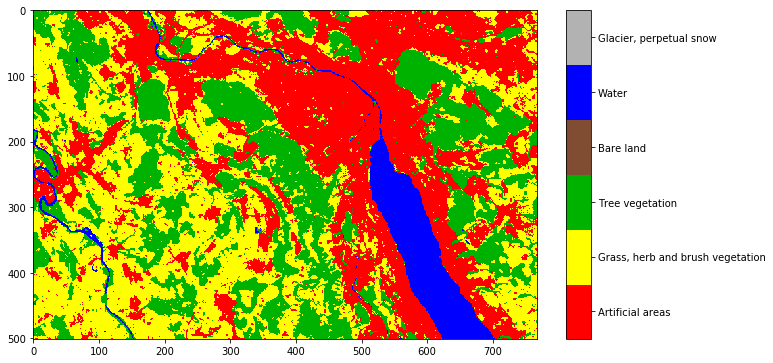

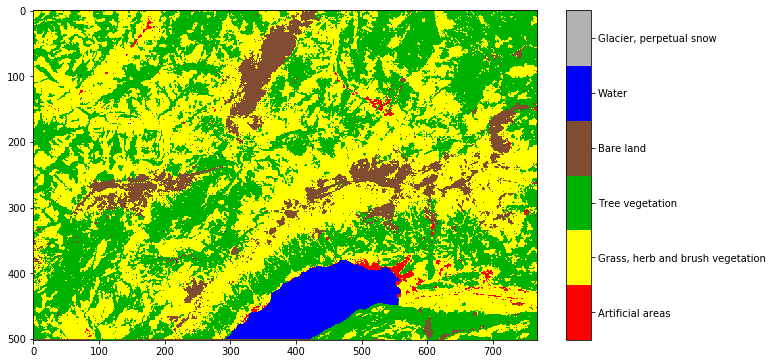

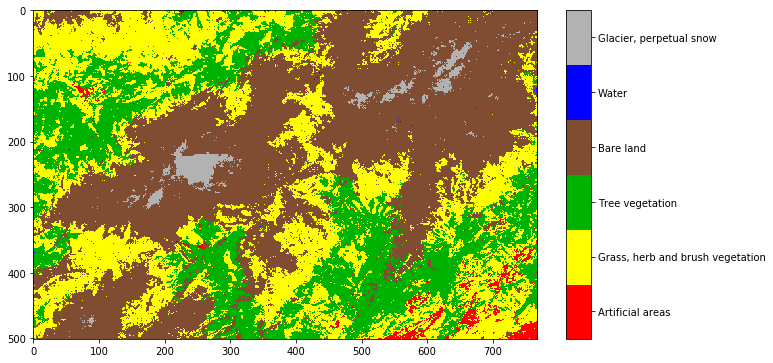

Arealstatistik 2013/18
Summary statistics (n Samples: 30990)

83.86 % (OA)
86.79 % (Average UA)
79.56 % (Average PA)
86.79 % (AA = Average UA)
85.33 % (MA = (OA + AA)/2)
0.78 (Kappa)

0: 88.39 % (UA) n Class: 3771; 80.62 % (PA) n Ref: 4134)
1: 78.41 % (UA) n Class: 11339; 84.36 % (PA) n Ref: 10539)
2: 85.69 % (UA) n Class: 9188; 85.36 % (PA) n Ref: 9223)
3: 86.36 % (UA) n Class: 5446; 83.39 % (PA) n Ref: 5640)
4: 97.60 % (UA) n Class: 1042; 89.52 % (PA) n Ref: 1136)
5: 84.31 % (UA) n Class: 204; 54.09 % (PA) n Ref: 318)


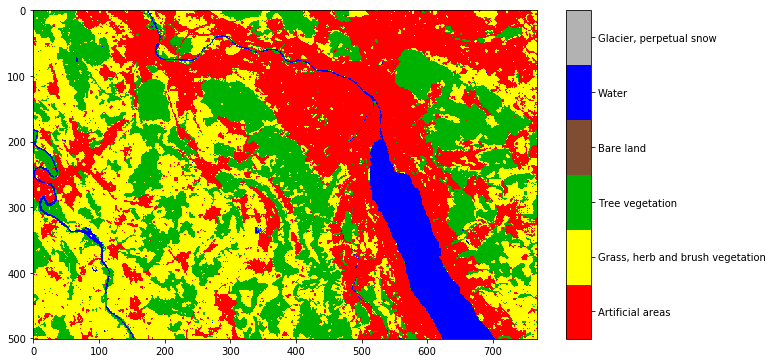

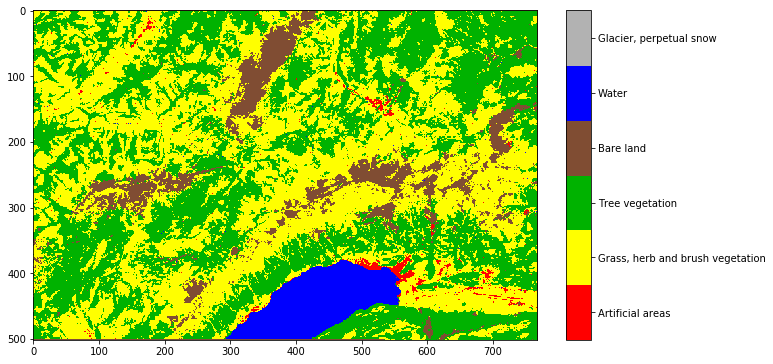

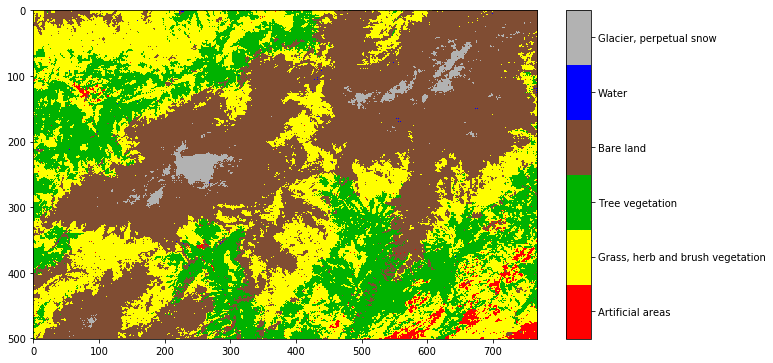

In [3]:
# comparison arealstatistik 2004 vs. 2013


rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]


coefs_as2004 = pd.read_csv(f'data/classification_data/coefficients_labeled_as2004.csv')
coefs_as2013 = pd.read_csv(f'data/classification_data/coefficients_labeled_as2013.csv')
            
test_size = 0.3
clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')


# container for best working classifiers and their overall accuracy
best_working = {}
def update_best_working(method,arealstatistik,candidate):
    can = copy.deepcopy(candidate)
    best_so_far = best_working.get(f'{method}_{arealstatistik}',False)
    if not best_so_far:
        best_working[f'{method}_{arealstatistik}'] = can
    else:
        if best_so_far[1].score()<can[1].score():
            best_working[f'{method}_{arealstatistik}'] = can
            
    # end of update best working classifier function

# data container and function to add data to it
data = []

# define number of iterations
n_iterations = 10

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    # splitting data into test and training
    train_as2004, test_as2004 = train_test_split(coefs_as2004, test_size=test_size)
    train_as2013, test_as2013 = train_test_split(coefs_as2013, test_size=test_size)
    
    # Arealstatistik 2004/09
    error_matrix, run_time, trained_clf = train_validate_classifier(clf,train_as2004,test_as2004,features_ts,label)
    ametrics = error_matrix.accuracy_metrics()
    data.append(('rf_ts','as2004',test_size,run_time,ametrics))
    update_best_working('rf_ts','as2004',(trained_clf,error_matrix))
    
    # Arealstatistik 2009/18
    error_matrix, run_time, trained_clf = train_validate_classifier(clf,train_as2013,test_as2013,features_ts,label)
    ametrics = error_matrix.accuracy_metrics()
    data.append(('rf_ts','as2013',test_size,run_time,ametrics))
    update_best_working('rf_ts','as2013',(trained_clf,error_matrix))
    
d = {
    'method': [entry[0] for entry in data],
    'arealstatistik': [entry[1] for entry in data],
    'testsize': [f'{entry[2]:.2f}' for entry in data],
    'runtime': [entry[3] for entry in data],
    'OA': [entry[4]['OA'] for entry in data],
    'AvgUA': [entry[4]['AvgUA'] for entry in data],
    'AvgPA': [entry[4]['AvgPA'] for entry in data],
    'AA': [entry[4]['AA'] for entry in data],
    'MA': [entry[4]['MA'] for entry in data],
    'Kappa': [entry[4]['Kappa'] for entry in data],
}
df = pd.DataFrame(data=d)
df.to_csv(f'{path}arealstatistik_comparison_rf_ts.csv', encoding='utf-8', index=False)
print(df.groupby(['arealstatistik'])[('OA','AA','MA','Kappa')].mean())
print(df.groupby(['arealstatistik'])[('OA','AA','MA','Kappa')].std())

print('Arealstatistik 2009/13')
trained_clf, error_matrix = best_working[f'rf_ts_as2013']
error_matrix.print_summary()
for roi in rois:
    fname = f'data/coefficients/coefficients_{roi}_{collection_year(roi,2013)}.tif'    
    coefficients_classified, geotransform, epsg = classify(trained_clf,fname,spatial=True)
    save_geotiff(coefficients_classified,geotransform,epsg,f'data/classification_data/as2004_{roi}_rf_ts')
    plot(coefficients_classified)
    
print('Arealstatistik 2013/18')
error_matrix_as2013, _, clf_as2013 = train_validate_classifier(clf,train_as2013,test_as2013,features_ts,label)
error_matrix_as2013.print_summary()
for roi in rois:
    fname = f'data/coefficients/coefficients_{roi}_{collection_year(roi,2013)}.tif'    
    coefficients_classified, geotransform, epsg = classify(clf_as2013,fname,spatial=True)
    save_geotiff(coefficients_classified,geotransform,epsg,f'data/classification_data/as2013_{roi}_rf_ts')
    plot(coefficients_classified)
            

                       OA         AA         MA     Kappa
arealstatistik                                           
as2004          82.861836  88.010524  85.436180  0.767126
as2013          84.007744  86.812247  85.409996  0.783289
                      OA        AA        MA     Kappa
arealstatistik                                        
as2004          0.167287  0.343475  0.233163  0.002203
as2013          0.166877  0.253178  0.165475  0.002269


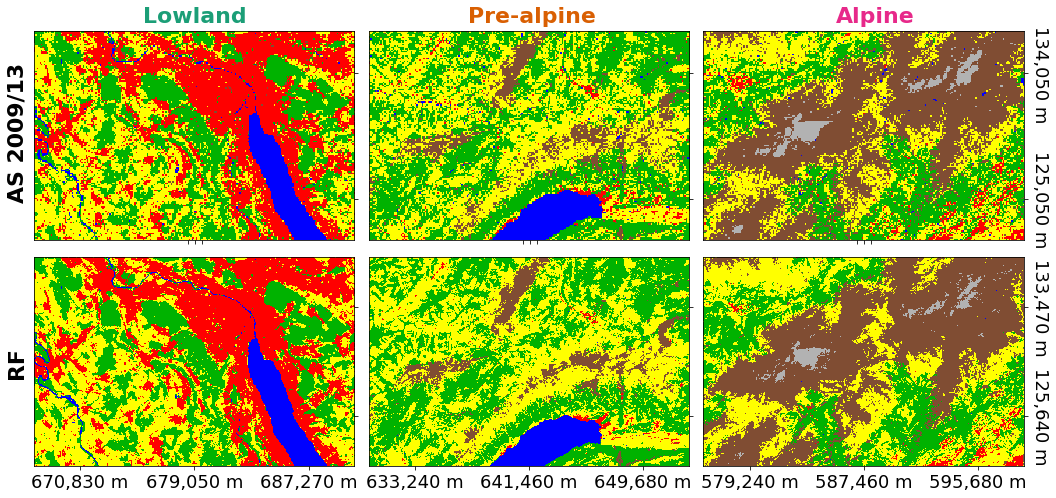

In [10]:
classifier = 'rf'
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']

df = pd.read_csv('data/classification_data/arealstatistik_comparison_rf_ts.csv')
grouped = df.groupby(['arealstatistik'])[('OA','AA','MA','Kappa')]
print(grouped.mean())
print(grouped.std())

fontsize_title = 22
fontsize = 18


fig, axs = plt.subplots(2,3, figsize=(18,8), facecolor='w', edgecolor='k') # w h
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.08, wspace=0.0)
axs = axs.ravel()


for i, roi in enumerate(rois):
    ax = axs[i]
        
    x_labels = False
    y_labels = True if i+1==len(rois) else False
        
    fname = f'data/arealstatistik/validation_{roi}_as2013.tif'
    plot_classification(ax,fname,x_labels,y_labels)

for i, roi in enumerate(rois):
    ax = axs[len(rois)+i]
        
    x_labels = True
    y_labels = True if i+1==len(rois) else False
        
    fname = f'data/classification_data/as2013_{roi}_rf_ts.tif'
    plot_classification(ax,fname,x_labels,y_labels)
        
    
fig.text(0.255, 0.895, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
fig.text(0.515, 0.895, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.78, 0.895, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')

fig.text(0.11, 0.705, 'AS 2009/13', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.11, 0.305, 'RF', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'plots/visual_comparison_as2013.png', dpi=300, bbox_inches = "tight")


In [43]:
# change detection

folder_validation = 'data/arealstatistik/'
folder_maps = 'data/classification_data/'

rois = ['roi1','roi2','roi3']


def get_change(fname_t1,fname_t2):
    
    map_t1, geotransform, epsg = geotiff_to_datacube(fname_t1)
    map_t2, _, _ = geotiff_to_datacube(fname_t2)

    shape = map_t1.shape
    change = np.zeros((shape[0],shape[1]),dtype=np.int)
    
    for index, _ in np.ndenumerate(change):
        irow, icol = index
        
        lc_t1 = map_t1[irow,icol]
        lc_t2 = map_t2[irow,icol]
        if lc_t1!=lc_t2 and lc_t1!=-1 and lc_t2!=-1:
            change[irow,icol] = 1
    
    return change, geotransform, epsg
    # end of get change function

for iroi, roi in enumerate(rois):
    
    # change validation
    fname_val_as2004 = f'{folder_validation}validation_{roi}_as2004.tif'
    fname_val_as2013 = f'{folder_validation}validation_{roi}_as2013.tif'
    change_val, geotransform, epsg = get_change(fname_val_as2004,fname_val_as2013)
    save_geotiff(change_val,geotransform,epsg,f'{folder_maps}change_validation_{roi}')
    
    # change classification
    fname_class_as2004 = f'{folder_maps}rf_ts_{roi}_as2004.tif'
    fname_class_as2013 = f'{folder_maps}rf_ts_{roi}_as2013.tif'
    change_class, geotransform, epsg = get_change(fname_class_as2004,fname_class_as2013)
    save_geotiff(change_class,geotransform,epsg,f'{folder_maps}change_rf_ts_{roi}')
    
    
    

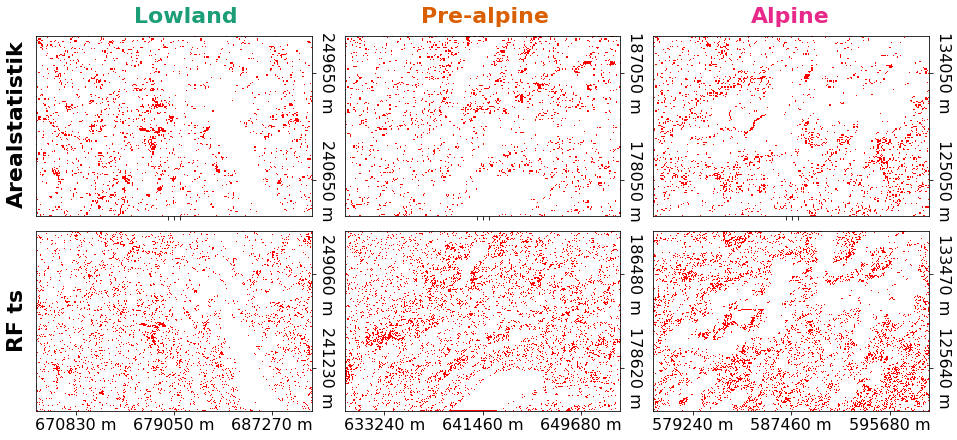

In [45]:
# plot change


def plot_change(ax,fname,show_xlabels=True,show_ylabels=True):
    
    cmap = mpl.colors.ListedColormap(['#ffffff','#ff0000'])
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,2), cmap.N)
    
    change, geotransform, epsg = geotiff_to_datacube(fname)
    shape = (change.shape[0], change.shape[1], 1)
    
    im = ax.imshow(change[:,:,0], cmap=cmap, norm=norm)
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,shape[1]//2,shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    return



rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
roi_colors = ['#1b9e77','#d95f02','#e7298a']



folder_maps = 'data/classification_data/'


fontsize_title = 22
fontsize = 16

fig, axs = plt.subplots(2,3, figsize=(16,7), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.05, wspace=0.12)
axs = axs.ravel()

for iroi, roi in enumerate(rois):
    
    plot_change(axs[iroi],f'{folder_maps}change_validation_{roi}.tif',False)
    plot_change(axs[iroi+3],f'{folder_maps}change_rf_ts_{roi}.tif')

fig.text(0.1, 0.7, 'Arealstatistik', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.1, 0.31, 'RF ts', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
    
fig.text(0.255, 0.9, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
fig.text(0.515, 0.9, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.78, 0.9, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')

plt.savefig(f'plots/change_maps.png', dpi=300, bbox_inches = "tight")

In [33]:
# class that provides methods to assess classification results by implementing various accuracy metrics.
class ErrorMatrix:

    
    def __init__(self,matrix,labels=False):
        
        self.matrix = matrix
        self.n_classes = matrix.shape[0]

        self.labels = labels if labels else list(range(self.n_classes))
        
        
    def column_total(self):
        return list(np.sum(self.matrix, axis=0))
        
    
    def row_total(self):
        return list(np.sum(self.matrix, axis=1))
    
    def total(self):
        return sum(self.column_total())
                
    def users_accuracy(self,i):
        total = np.sum(self.matrix[i,:])
        if total==0: return 0.0
        else: return self.matrix[i,i]/float(total)*100
    
    def users_accuracies(self):
        uas = [self.users_accuracy(i) for i in range(self.n_classes)]
        return uas

    def average_users_accuracy(self):
        return np.mean(self.users_accuracies())

    def producers_accuracy(self,i):
        total = np.sum(self.matrix[:,i])
        if total==0: return 0.0
        else: return self.matrix[i,i]/float(total)*100
    
    def producers_accuracies(self):
        pas = [self.producers_accuracy(i) for i in range(self.n_classes)]
        return pas
    
    def average_producers_accuracy(self):
        return np.mean(self.producers_accuracies())
    
    def overall_accuracy(self):
        correctly_classified = sum([self.matrix[i,i] for i in range(self.n_classes)])
        total = sum(list(np.sum(self.matrix, axis=1)))
        oa = correctly_classified/float(total)*100
        return oa
    
    def average_accuracy(self):
        aa = np.mean(self.users_accuracies())
        return aa

    def mean_accuracy(self):
        ma = (self.average_accuracy()+self.overall_accuracy())/2.
        return ma
     
    def kappa(self):  
        # Cohen's kappa (Cohen, 1960; doi:10.1177/001316446002000104)
        X_test, y_pred = ([],[])
        for index, value in np.ndenumerate(self.matrix):
            pred, label = index
            X_test.extend([label for _ in range(value)])
            y_pred.extend([pred for _ in range(value)])
        return cohen_kappa_score(X_test,y_pred)
    
    def score(self):    
        aua = self.average_users_accuracy()
        apa = self.average_producers_accuracy()
        return aua + apa
    
    def accuracy_metrics(self):   
        metrics = {
            'OA': self.overall_accuracy(),
            'AvgUA': self.average_users_accuracy(),
            'AvgPA': self.average_producers_accuracy(),
            'AA': self.average_accuracy(),
            'MA': self.mean_accuracy(),
            'Kappa': self.kappa()
        }
        return metrics
            
    def print_matrix(self):  
        print(self.matrix)
        
    def print_summary(self):      
        
        print(f'Summary statistics (n Samples: {self.total()})')    
        print()   
        # overall statistics        
        print(f'{self.overall_accuracy():.2f} % (OA)')
        print(f'{self.average_users_accuracy():.2f} % (Average UA)')
        print(f'{self.average_producers_accuracy():.2f} % (Average PA)')
        print(f'{self.average_accuracy():.2f} % (AA = Average UA)')
        print(f'{self.mean_accuracy():.2f} % (MA = (OA + AA)/2)')        
        print(f'{self.kappa():.2f} (Kappa)')      
        print()     
        # class wise statistics
        column_total = self.column_total()
        row_total = self.row_total()      
        uas = self.users_accuracies()
        pas = self.producers_accuracies()      
        for i, label in enumerate(self.labels):
            print(f'{label}: {uas[i]:.2f} % (UA) n Class: {row_total[i]}; {pas[i]:.2f} % (PA) n Ref: {column_total[i]})')
                 
    def write2latex(self,fname,labels=False):
        
        labels = labels if labels else [f'{i}' for i in range(self.n_classes)]
        
        f = open(f'{fname}.txt', 'w')
        
        f.write('\\begin{table}[h!] \n')
        f.write('\\begin{center} \n')
        f.write('\\caption{Error matrix.} \n')
        f.write('\\label{tab:error_matrix} \n')
        f.write(f'\\resizebox{{0.99\\textwidth}}{{!}}{{\\begin{{tabular}}{{l{"r"*(self.n_classes+3)}}} \n')
        f.write('\\toprule \n')
        f.write(f' & \multicolumn{{{self.n_classes+1}}}{{l}}{{Reference data (pixels)}} & UA (\\%) & PA (\\%) \\\ \n')
        f.write(f'\\cmidrule{{2-{self.n_classes+4}}} \n')
        f.write(f'& {" & ".join(labels)} & Total & & \\\ \n') 
        f.write('\\bottomrule \n')
        f.write(f'Class (pixels) {"& "*6}\\\ \n')
        
        
        for i in range(self.n_classes):
            line = ' & '.join([f'{v}' for v in self.matrix[i,:]])
            line =  f'{labels[i]} & {line} & {self.row_total()[i]} & {self.users_accuracies()[i]:.2f} & {self.producers_accuracies()[i]:.2f} \\\ \n'        
            f.write(line)
            
        line = ' & '.join([f'{t}' for t in self.column_total()])
        line = f'Total & {line} & {self.total()} & & \\\ \n'
        f.write(line)
        f.write('\\bottomrule \n')
        f.write('\\end{tabular}} \n')
        f.write('\\end{center} \n')
        f.write('\\end{table}')
                
        f.close()
        # end of matrix to latex function
                
    def users_producers2latex(self,fname,labels=False):        
        labels = labels if labels else [f'{i}' for i in range(self.n_classes)]
        
        f = open(f'{fname}.txt', 'w')
        
        
        line = ' & '.join([f'{ua:.2f}' for ua in self.users_accuracies()])
        f.write(f'{line} \\\ \n')
        line = ' & '.join([f'{pa:.2f}' for pa in self.producers_accuracies()])
        f.write(f'{line} \\\ \n')
                
        f.close()
        # end of user producer to latex function
                

        

            
m = np.array([
    [21,6,0],
    [5,31,1],
    [7,2,22],
])                

m = np.array([
    [0,0,0],
    [5,0,1],
    [7,0,22],
])


    
                
em = ErrorMatrix(m)
# em.users_producers2latex('test')
em.users_accuracies()

[0.0, 0.0, 75.86206896551724]

In [99]:
# class that provides methods to assess classification results by implementing various accuracy metrics.
class ErrorMatrix:

    def __init__(self, y_ref, y_pred, labels=False):
        
        self.y_ref = list(y_ref)
        self.y_pred = list(y_pred)
        self.n_classes = len(np.unique(self.y_ref))
        
        self.matrix = np.zeros((self.n_classes,self.n_classes),dtype=np.int)
        for r, p in zip(y_ref,y_pred):
            self.matrix[p,r] = self.matrix[p,r]+1
        
        self.labels = labels if labels else list(range(self.n_classes))        
        
    def column_total(self):
        return list(np.sum(self.matrix, axis=0))
        
    def row_total(self):
        return list(np.sum(self.matrix, axis=1))
    
    def total(self):
        return sum(self.column_total())
                
    def users_accuracy(self,i):
        total = np.sum(self.matrix[i,:])
        if total==0: return 0.0
        else: return self.matrix[i,i]/float(total)*100
    
    def users_accuracies(self):
        uas = [self.users_accuracy(i) for i in range(self.n_classes)]
        return uas

    def average_users_accuracy(self):
        return np.mean(self.users_accuracies())

    def producers_accuracy(self,i):
        total = np.sum(self.matrix[:,i])
        if total==0: return 0.0
        else: return self.matrix[i,i]/float(total)*100
    
    def producers_accuracies(self):
        pas = [self.producers_accuracy(i) for i in range(self.n_classes)]
        return pas
    
    def average_producers_accuracy(self):
        return np.mean(self.producers_accuracies())
    
    def overall_accuracy(self):
        correctly_classified = sum([self.matrix[i,i] for i in range(self.n_classes)])
        total = sum(list(np.sum(self.matrix, axis=1)))
        oa = correctly_classified/float(total)*100
        return oa
    
    def average_accuracy(self):
        aa = np.mean(self.users_accuracies())
        return aa

    def mean_accuracy(self):
        ma = (self.average_accuracy()+self.overall_accuracy())/2.
        return ma
     
    def kappa(self):  
        # Cohen's kappa (Cohen, 1960; doi:10.1177/001316446002000104)
        return cohen_kappa_score(self.y_ref,self.y_pred)
    
    def score(self):    
        aua = self.average_users_accuracy()
        apa = self.average_producers_accuracy()
        return aua + apa
    
    def accuracy_metrics(self):   
        metrics = {
            'OA': self.overall_accuracy(),
            'AvgUA': self.average_users_accuracy(),
            'AvgPA': self.average_producers_accuracy(),
            'AA': self.average_accuracy(),
            'MA': self.mean_accuracy(),
            'Kappa': self.kappa()
        }
        return metrics
            
    def print_matrix(self):  
        print(self.matrix)
        
    def print_summary(self):      
        
        print(f'Summary statistics (n Samples: {self.total()})')    
        print()   
        # overall statistics        
        print(f'{self.overall_accuracy():.2f} % (OA)')
        print(f'{self.average_users_accuracy():.2f} % (Average UA)')
        print(f'{self.average_producers_accuracy():.2f} % (Average PA)')
        print(f'{self.average_accuracy():.2f} % (AA = Average UA)')
        print(f'{self.mean_accuracy():.2f} % (MA = (OA + AA)/2)')        
        print(f'{self.kappa():.2f} (Kappa)')      
        print()     
        # class wise statistics
        column_total = self.column_total()
        row_total = self.row_total()      
        uas = self.users_accuracies()
        pas = self.producers_accuracies()      
        for i, label in enumerate(self.labels):
            print(f'{label}: {uas[i]:.2f} % (UA) n Class: {row_total[i]}; {pas[i]:.2f} % (PA) n Ref: {column_total[i]})')
                 
    def write2latex(self,fname,labels=False):
        
        labels = labels if labels else [f'{i}' for i in range(self.n_classes)]
        f = open(f'{fname}.txt', 'w')
        f.write('\\begin{table}[h!] \n')
        f.write('\\begin{center} \n')
        f.write('\\caption{Error matrix.} \n')
        f.write('\\label{tab:error_matrix} \n')
        f.write(f'\\resizebox{{0.99\\textwidth}}{{!}}{{\\begin{{tabular}}{{l{"r"*(self.n_classes+3)}}} \n')
        f.write('\\toprule \n')
        f.write(f' & \multicolumn{{{self.n_classes+1}}}{{l}}{{Reference data (pixels)}} & UA (\\%) & PA (\\%) \\\ \n')
        f.write(f'\\cmidrule{{2-{self.n_classes+4}}} \n')
        f.write(f'& {" & ".join(labels)} & Total & & \\\ \n') 
        f.write('\\bottomrule \n')
        f.write(f'Class (pixels) {"& "*6}\\\ \n')
        
        for i in range(self.n_classes):
            line = ' & '.join([f'{v}' for v in self.matrix[i,:]])
            line =  f'{labels[i]} & {line} & {self.row_total()[i]} & {self.users_accuracies()[i]:.2f} & {self.producers_accuracies()[i]:.2f} \\\ \n'        
            f.write(line)
            
        line = ' & '.join([f'{t}' for t in self.column_total()])
        line = f'Total & {line} & {self.total()} & & \\\ \n'
        f.write(line)
        f.write('\\bottomrule \n')
        f.write('\\end{tabular}} \n')
        f.write('\\end{center} \n')
        f.write('\\end{table}')
        f.close()
        # end of matrix to latex function
                
    def users_producers2latex(self,fname,labels=False):        
        labels = labels if labels else [f'{i}' for i in range(self.n_classes)]
        f = open(f'{fname}.txt', 'w')
        line = ' & '.join([f'{ua:.2f}' for ua in self.users_accuracies()])
        f.write(f'{line} \\\ \n')
        line = ' & '.join([f'{pa:.2f}' for pa in self.producers_accuracies()])
        f.write(f'{line} \\\ \n')        
        f.close()
        # end of user producer to latex function
                
                
arr = np.array([[21,6,0],[5,31,1],[7,2,22]])
                
y_ref, y_pred = ([],[])
                
for index, x in np.ndenumerate(arr):
    for i in range(x):
        y_ref.append(index[1])
        y_pred.append(index[0])
                
ErrorMatrix(y_ref,y_pred).print_summary()

Summary statistics (n Samples: 95)

77.89 % (OA)
77.51 % (Average UA)
79.59 % (Average PA)
77.51 % (AA = Average UA)
77.70 % (MA = (OA + AA)/2)
0.67 (Kappa)

0: 77.78 % (UA) n Class: 27; 63.64 % (PA) n Ref: 33)
1: 83.78 % (UA) n Class: 37; 79.49 % (PA) n Ref: 39)
2: 70.97 % (UA) n Class: 31; 95.65 % (PA) n Ref: 23)


In [38]:
arr = np.array([
    [3243,259,125,59,20,0],
    [647,9287,1308,710,35,0], 
    [143,1038,7374,154,38,0],
    [32,388,87,4702,32,68],
    [9,7,8,0,1018,0],
    [0,0,0,11,0,248]
])

em = ErrorMatrix([],[])
em.set_matrix(arr)
em.print_summary()
em.kappa()

Summary statistics (n Samples: 31050)

83.32 % (OA)
88.55 % (Average UA)
83.00 % (Average PA)
88.55 % (AA = Average UA)
85.94 % (MA = (OA + AA)/2)
0.77 (Kappa)

0: 87.51 % (UA) n Class: 3706; 79.60 % (PA) n Ref: 4074)
1: 77.48 % (UA) n Class: 11987; 84.59 % (PA) n Ref: 10979)
2: 84.30 % (UA) n Class: 8747; 82.84 % (PA) n Ref: 8902)
3: 88.57 % (UA) n Class: 5309; 83.43 % (PA) n Ref: 5636)
4: 97.70 % (UA) n Class: 1042; 89.06 % (PA) n Ref: 1143)
5: 95.75 % (UA) n Class: 259; 78.48 % (PA) n Ref: 316)


0.7730226035968394